In [1]:
%matplotlib inline

import pandas as pd, numpy as np
import matplotlib.pyplot as plt, scipy.stats as st
import seaborn as sns
sns.set(style='darkgrid')
from gbd_mapping import causes
from db_queries import get_outputs, get_ids
from matplotlib.backends.backend_pdf import PdfPages
import warnings
warnings.filterwarnings('ignore')
!date
!whoami
#This notebook revised from Yongquan's data processing and validation notebooks 

Mon Mar 30 13:48:34 PDT 2020
yaqiw


In [2]:
result_dir = '/ihme/costeffectiveness/results/vivarium_conic_lsff/v4.0_folic_acid_fortification/'
filePath = {
    'Ethiopia': result_dir + 'ethiopia/2020_03_18_23_04_26/output.hdf',
    'India': result_dir + 'india/2020_03_18_23_04_36/output.hdf',
    'Nigeria': result_dir + 'nigeria/2020_03_18_23_04_42/output.hdf'
}
cause_names = ['vitamin_a_deficiency', 'measles', 'diarrheal_diseases', 'lower_respiratory_infections', 'iron_deficiency', 'neural_tube_defects', 'other_causes']
template_cols = ['cause', 'sex', 'age_group', 'intervention_status', 'measure', 'input_draw']

### 1. Data Processing

In [3]:
def load_data(country_path: str):
    df = pd.read_hdf(country_path)
    df = df.loc[df['fortification_intervention.scenario'] == 'baseline'] #pick out baseline
    df = df.groupby('input_draw').sum()
    return df

In [4]:
def get_sex_from_template(template_string):
    return template_string.split('_among_')[1].split('_in_')[0].capitalize()

def get_age_group_from_template(template_string):
    return '_'.join(template_string.split('_age_group_')[1].split('_')[:-5])

def get_intervention_status_from_template(template_string):
    return '_'.join(template_string.split('_')[-5:])

In [5]:
def standardize_shape(data: pd.DataFrame, measure: str):
    """select specific measure of data and unpivot it into long-format dataframe"""
    if 'due_to' in measure:
        measure_data = data[[c for c in data.columns if measure in c]]
        measure_data = measure_data.reset_index().melt(id_vars='input_draw', var_name='label')
        measure, cause = measure.split('_due_to_', 1)
        measure_data['measure'] = measure
        measure_data['cause'] = cause
    else:
        measure_data = data.loc[:, data.columns.str.startswith('person_time')]
        measure_data = measure_data.reset_index().melt(id_vars=['input_draw'], var_name=['label'])
        measure_data['measure'] = measure
    
    measure_data['sex'] = measure_data.label.map(get_sex_from_template)
    measure_data['age_group'] = measure_data.label.map(get_age_group_from_template)
    measure_data['intervention_status'] = measure_data.label.map(get_intervention_status_from_template)
    
    measure_data.drop(columns='label', inplace=True)
    
    return measure_data

In [6]:
def get_disaggregated_results(data, cause_names):
    deaths = []
    ylls = []
    ylds = []
    for cause in cause_names:
        deaths.append(standardize_shape(data, f'death_due_to_{cause}'))
        ylls_sub = standardize_shape(data, f'ylls_due_to_{cause}')
        ylls.append(ylls_sub)
        if cause != 'other_causes':
            ylds_sub = standardize_shape(data, f'ylds_due_to_{cause}')    
            ylds.append(ylds_sub)
            
    
    death_data = pd.concat(deaths)
    yll_data = pd.concat(ylls)
    yld_data = pd.concat(ylds)
    
    output = pd.concat([death_data, yll_data, yld_data])
    output = output.set_index(template_cols).sort_index()
    
    return output.reset_index()

In [7]:
def append_demographic_aggregates(data: pd.DataFrame, by_cause=False):
    """aggregate results on demographic groups and append it to input data"""
    extra_cols = ['cause'] if by_cause else []
    
    sex_aggregate = data.groupby(extra_cols + ['age_group', 'intervention_status', 'measure', 'input_draw']).value.sum().reset_index()
    sex_aggregate['sex'] = 'Both'

    data = pd.concat([data, sex_aggregate])
    
    age_aggregate = data.groupby(extra_cols + ['sex', 'intervention_status', 'measure', 'input_draw']).value.sum().reset_index()
    age_aggregate['age_group'] = '0-4'

    data = pd.concat([data, age_aggregate])
    
    risk_aggregate = data.groupby(extra_cols + ['sex', 'age_group', 'measure', 'input_draw']).value.sum().reset_index()
    risk_aggregate['intervention_status'] = 'all_population'

    data = pd.concat([data, risk_aggregate])
    
    data = data.set_index(extra_cols + template_cols[1:]).sort_index()
    
    return data.reset_index()

In [8]:
def append_cause_aggregates(data):
    cause_aggregate = data.groupby(template_cols[1:]).value.sum().reset_index()
    cause_aggregate['cause'] = 'all_causes'
    data = pd.concat([data, cause_aggregate])
    ###testing
    data['cause']= data['cause'].replace("iron_deficiency", "dietary_iron_deficiency")
    return data.set_index(template_cols).sort_index().reset_index()

In [9]:
def get_person_time(data):
    """pull person time and append demographic aggregates to it"""
    pt = standardize_shape(data, 'person_time')
    pt = append_demographic_aggregates(pt, by_cause=False)
    pt = pt.drop(columns='measure').rename(columns={'value': 'person_time'})
    
    return pt

In [10]:
def get_table_shell(results: pd.DataFrame, person_time: pd.DataFrame):
    results_w_pt = pd.merge(results, person_time, on=['sex', 'age_group', 'intervention_status', 'input_draw'])
    results_w_pt.rename(columns={'value': 'count'}, inplace=True)
    results_w_pt['rate'] = results_w_pt['count'] / results_w_pt['person_time'] * 100_000
    
    g = results_w_pt.groupby(template_cols[:-1])[['count', 'rate', 'person_time']].describe(percentiles=[.025, .975])
    t = g.loc[:, pd.IndexSlice[:, ['mean', '2.5%', '97.5%']]]
    t.columns = [f'{metric}_{val}' for metric, val in zip(t.columns.get_level_values(0), t.columns.get_level_values(1))]

    return t.reset_index()

### 2. Validation

In [11]:
gbd_names = ['all_causes', 'vitamin_a_deficiency', 'measles', 'diarrheal_diseases', 'lower_respiratory_infections', 'dietary_iron_deficiency', 
             'neural_tube_defects']

In [12]:
age_group_ids = list(range(2, 6)) 
age_table = get_ids('age_group')
age_table = age_table[age_table.age_group_id.isin(age_group_ids)]
age_table['age_group_name'] = age_table.age_group_name.map(lambda x: x.replace(' ', '_').lower())

age_dict = dict(zip(age_table.age_group_name, age_table.age_group_id))

In [13]:
def get_gbd_results(location_id: int, cause_names: list):
    ages = age_group_ids
    male, female, both = 1, 2, 3
    rate = 3
    deaths, ylds, ylls = 1, 3, 4
    
    cause_map = {c.gbd_id: c.name for c in causes if c.name in cause_names}

    gbd_outputs = get_outputs('cause', cause_id=list(cause_map.keys()), 
                              metric_id=[rate], measure_id=[deaths, ylls, ylds], 
                              sex_id = [male, female, both], age_group_id=ages,
                              location_id=location_id, gbd_round_id=5)


    gbd_outputs = gbd_outputs[['cause_id', 'age_group_name', 'measure_name', 'sex', 'val', 'upper', 'lower']]
    gbd_outputs['cause'] = gbd_outputs.cause_id.map(cause_map)
    gbd_outputs['measure'] = gbd_outputs.measure_name.map({'Deaths': 'death',
                                                           'YLLs (Years of Life Lost)': 'ylls',
                                                           'YLDs (Years Lived with Disability)': 'ylds'})
    gbd_outputs['age_group'] = gbd_outputs.age_group_name.str.replace(' ', '_').map(lambda x: x.lower())
    gbd_outputs = gbd_outputs.drop(columns=['cause_id', 'measure_name', 'age_group_name'])
    gbd_outputs[['val', 'upper', 'lower']] *= 100_000
    gbd_outputs = gbd_outputs.fillna(0.0)
    
    gbd_outputs = gbd_outputs.set_index(['cause', 'sex', 'measure']).sort_index().reset_index()
    
    return gbd_outputs

In [14]:
def aggregate_gbd_results(df: pd.DataFrame, cause_names: list):
    idx_cols = ['sex', 'age_group', 'measure']
    val_cols = ['val', 'upper', 'lower']
    sex = df.sex.unique()
    age_group = df.age_group.unique()
    measure = df.measure.unique()
    data = pd.DataFrame(0.0,
                        index=pd.MultiIndex.from_product([sex, age_group, measure], names=idx_cols),
                        columns=val_cols)
    for cause in cause_names:
        data += df.loc[df.cause == cause].drop(columns='cause').set_index(idx_cols)
    return data.reset_index()

In [15]:
#location_id for Nigeria is 214, for India is 163, for Ethiopia is 179

In [16]:
def make_plots(cause: str, sim_results: pd.DataFrame, gbd_results: pd.DataFrame, location: str, measure: str):
    sim_results = sim_results.loc[(sim_results.sex != 'Both')
                                  & (sim_results.age_group != '0-4')
                                  & (sim_results.intervention_status == 'all_population')]
    
    sim_results = sim_results.loc[sim_results.age_group.map(age_dict).sort_values().index]
    sim_results = sim_results.set_index(['cause', 'sex', 'intervention_status', 'measure']).sort_index().reset_index()
    sim_data = sim_results.loc[sim_results.cause == cause]
    sim_data['rate'] = sim_data['value'] / sim_data['person_time'] * 100_000
    
    sim_mean = sim_data.groupby(template_cols[:-1]).rate.mean().reset_index()
    sim_mean = sim_mean.loc[sim_mean.age_group.map(age_dict).sort_values().index]
    sim_mean = sim_mean.set_index(['cause', 'sex', 'intervention_status', 'measure']).sort_index().reset_index()
    
    gbd_data = gbd_results.loc[(gbd_results.sex != 'Both') & (gbd_results.cause == cause)]
    
    measure_s = sim_data.loc[sim_data.measure == measure]
    measure_m = sim_mean.loc[sim_mean.measure == measure]
    measure_g = gbd_data.loc[gbd_data.measure == measure]
    
    fig, ax = plt.subplots(figsize=(20, 10))
    clrs = sns.color_palette('husl', 2)

    g1 = sns.catplot(x='age_group', y='rate', 
                     hue='sex', palette=clrs, alpha=0.2, 
                     ax=ax, data=measure_s)

    sns.lineplot(x='age_group', y='val', 
                 hue='sex', palette=clrs, linewidth=2,
                 ax=ax, data=measure_g, sort=False)

    for i, sex in enumerate(['Female', 'Male']):
        sex_g = measure_g.loc[measure_g.sex == sex]
        ax.fill_between(sex_g.age_group, sex_g.upper, sex_g.lower, alpha=0.3, facecolor=clrs[i])
        
        sex_m = measure_m.loc[measure_m.sex == sex]
        ax.scatter(sex_m.age_group, sex_m.rate, s=250, color=clrs[i], marker='P', label=f'Sim {sex} mean')
        
    ax.set_title(f'{location}, {measure.capitalize()} due to {cause}', fontsize=20)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60, fontsize=16)
    #ax.set_xticks([c-0.2 for c in range(23)])
    ax.set_xlabel('Age group', fontsize=18)
    ax.set_ylabel(f'{measure.capitalize()} per 100k PY', fontsize=18)

    l = ax.legend(loc=(1.02, 0.05), fontsize=12)
    labels = ['GBD Female', 'GBD Male', 'Sim Female', 'Sim Male']
    for text, label in zip(l.texts[1:5], labels):
        text.set_text(label)

    plt.close(g1.fig)

In [17]:
def plot_multiple_locations(path_dict: dict, cause_names: list, gbd_names: list):
    location_table = get_ids('location')
    causes = ['all_causes', 'vitamin_a_deficiency', 'dietary_iron_deficiency','measles', 'diarrheal_diseases', 
              'lower_respiratory_infections', 'neural_tube_defects']
    measures = ['death', 'ylds', 'ylls']
    for location, path in path_dict.items():
        # sim results
        df = load_data(path)
        pt = get_person_time(df)
        output = get_disaggregated_results(df, cause_names)
        results = append_cause_aggregates(append_demographic_aggregates(output, by_cause=True))
        results_w_pt = pd.merge(results, pt, on=['sex', 'age_group', 'intervention_status', 'input_draw'])
        
        # gbd results
        location_id = location_table.loc[location_table.location_name == location].location_id.values
        gbd = get_gbd_results(location_id, gbd_names)
        with PdfPages(f'/home/j/Project/simulation_science/mnch/Interventions/large_scale_food_fortification/validation/model4/model4_validation_{location}.pdf') as pdf:
            for cause in causes:
                for measure in measures:
                    if ((cause == 'vitamin_a_deficiency') | (cause == 'dietary_iron_deficiency')) & ((measure == 'death')|(measure == 'ylls')):
                        continue
                    elif ((cause == 'measles') | (cause == 'lower_respiratory_infections') | (cause == 'neural_tube_defects')) & (measure == 'ylds'):
                        continue   
                    else: 
                        make_plots(cause, results_w_pt, gbd, location, measure)
                        pdf.savefig(bbox_inches='tight')
            

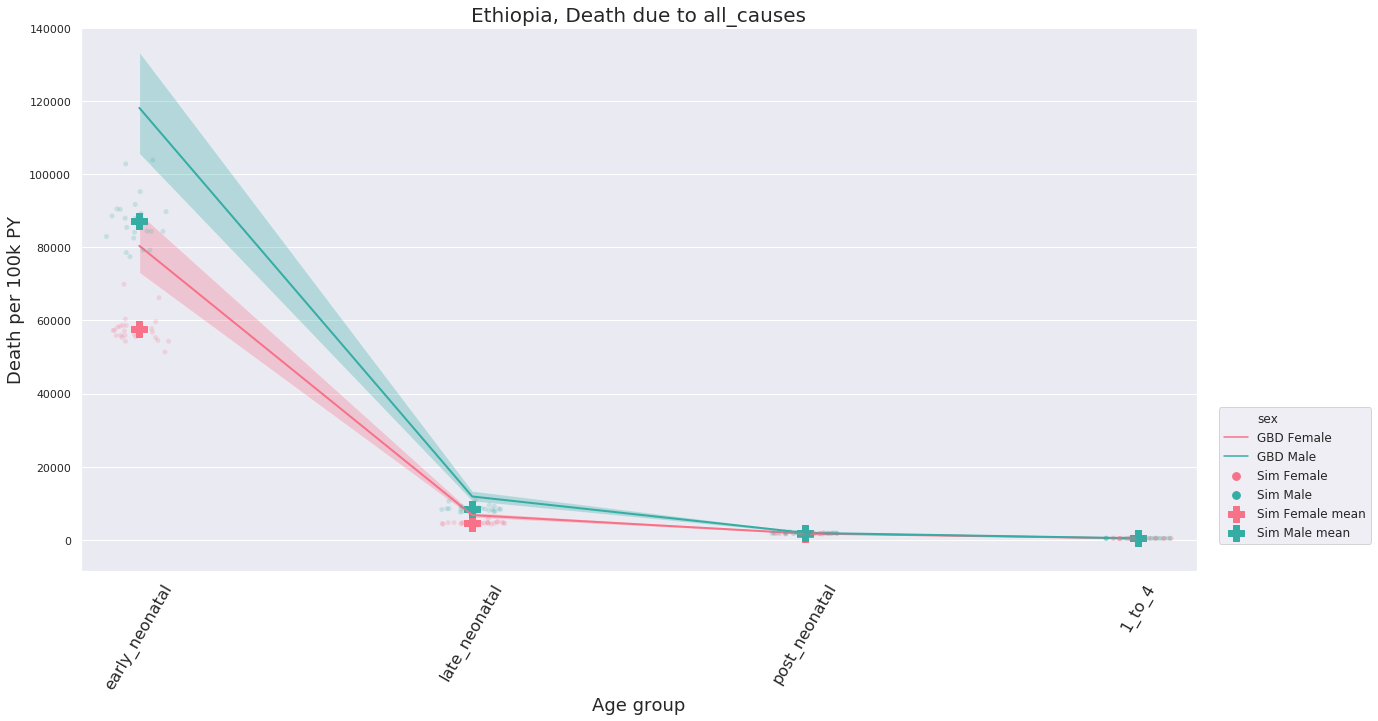

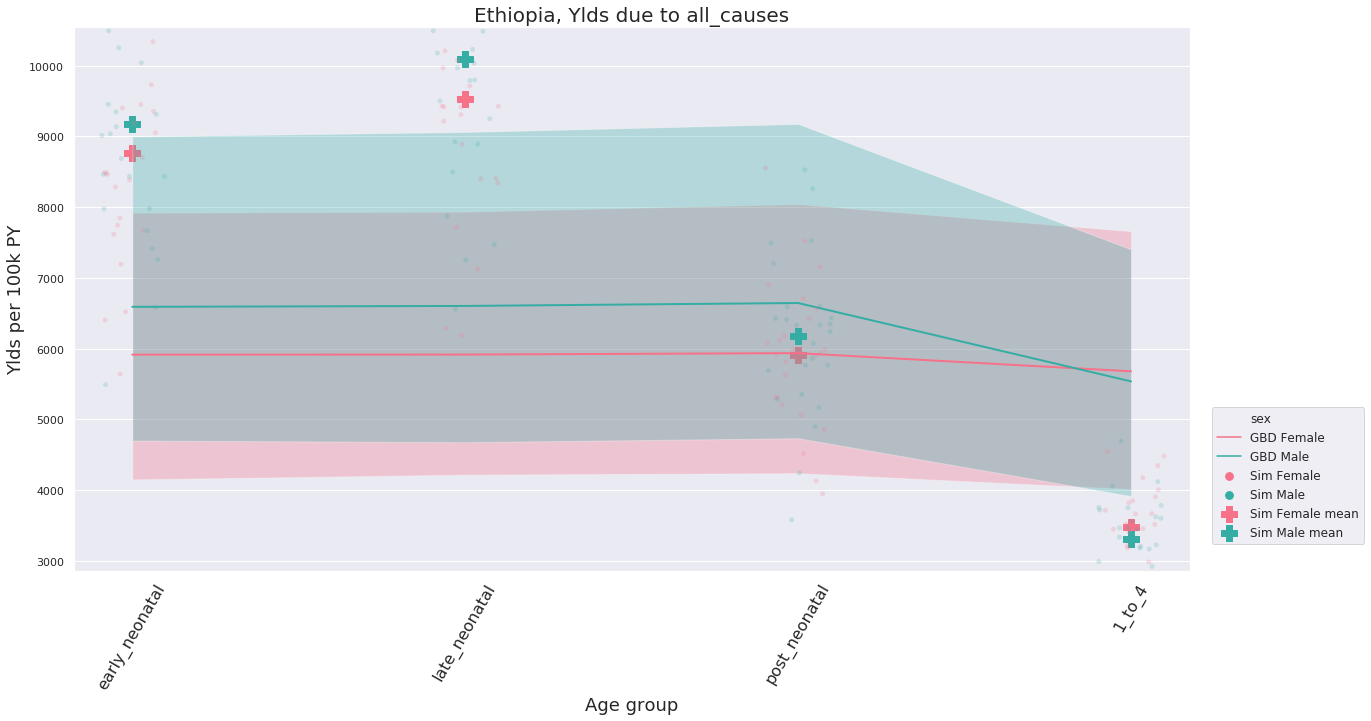

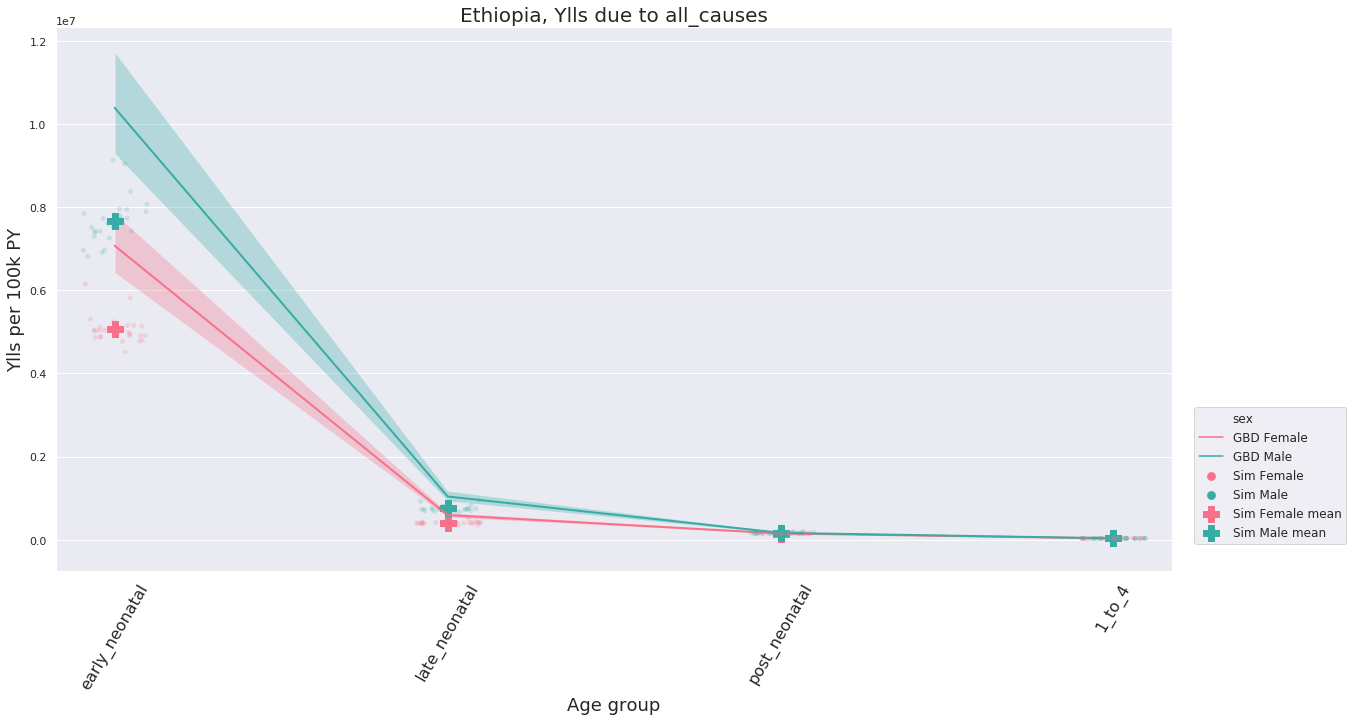

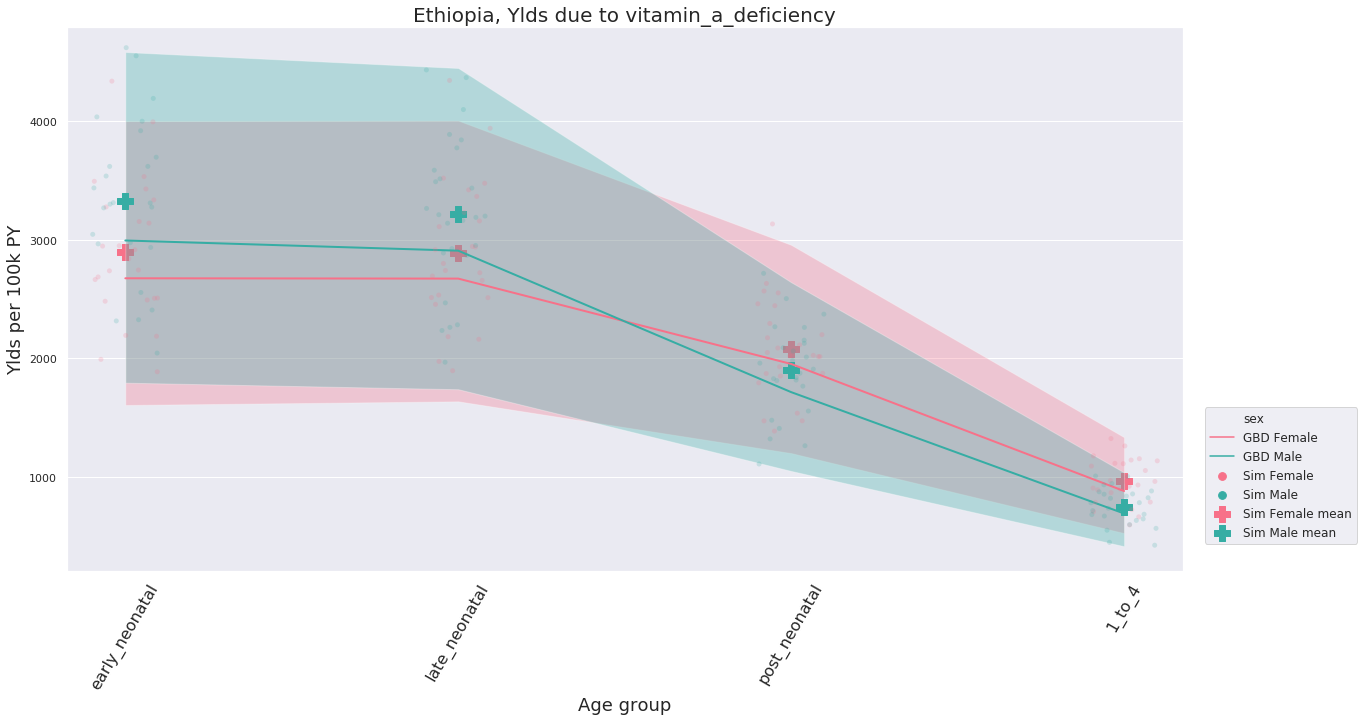

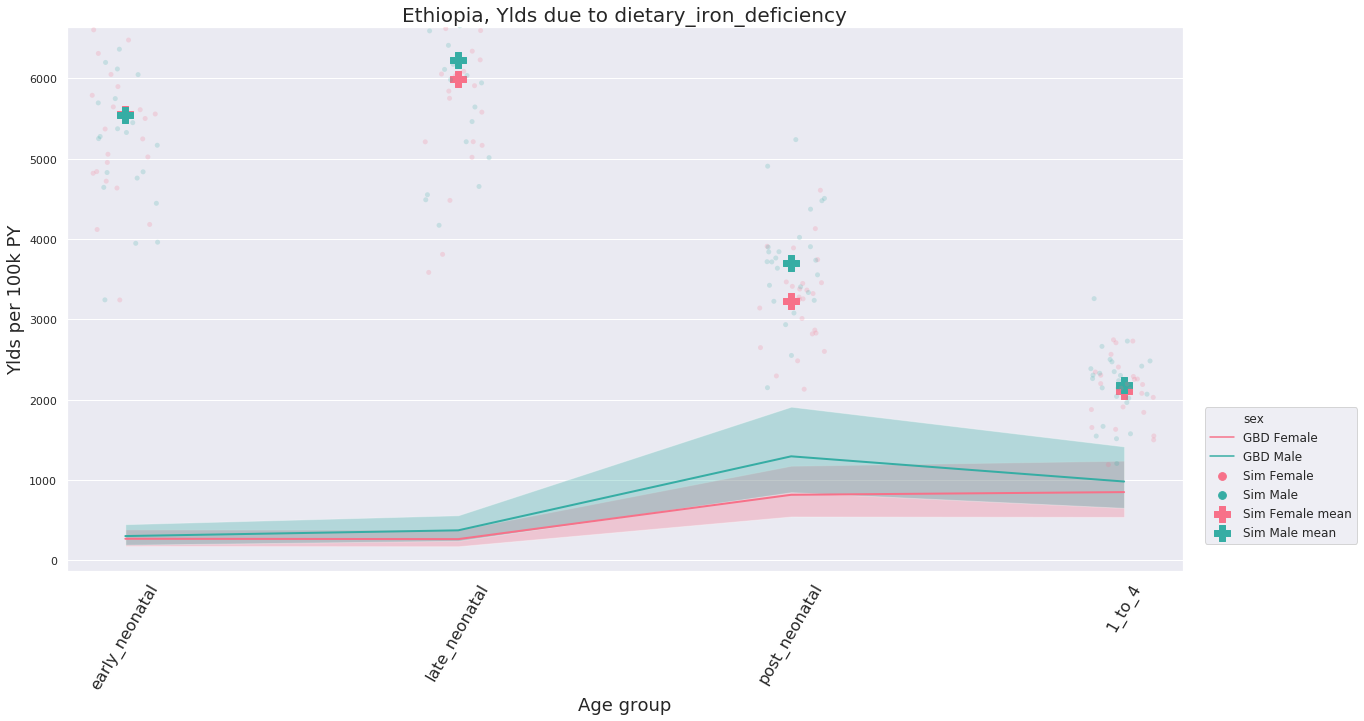

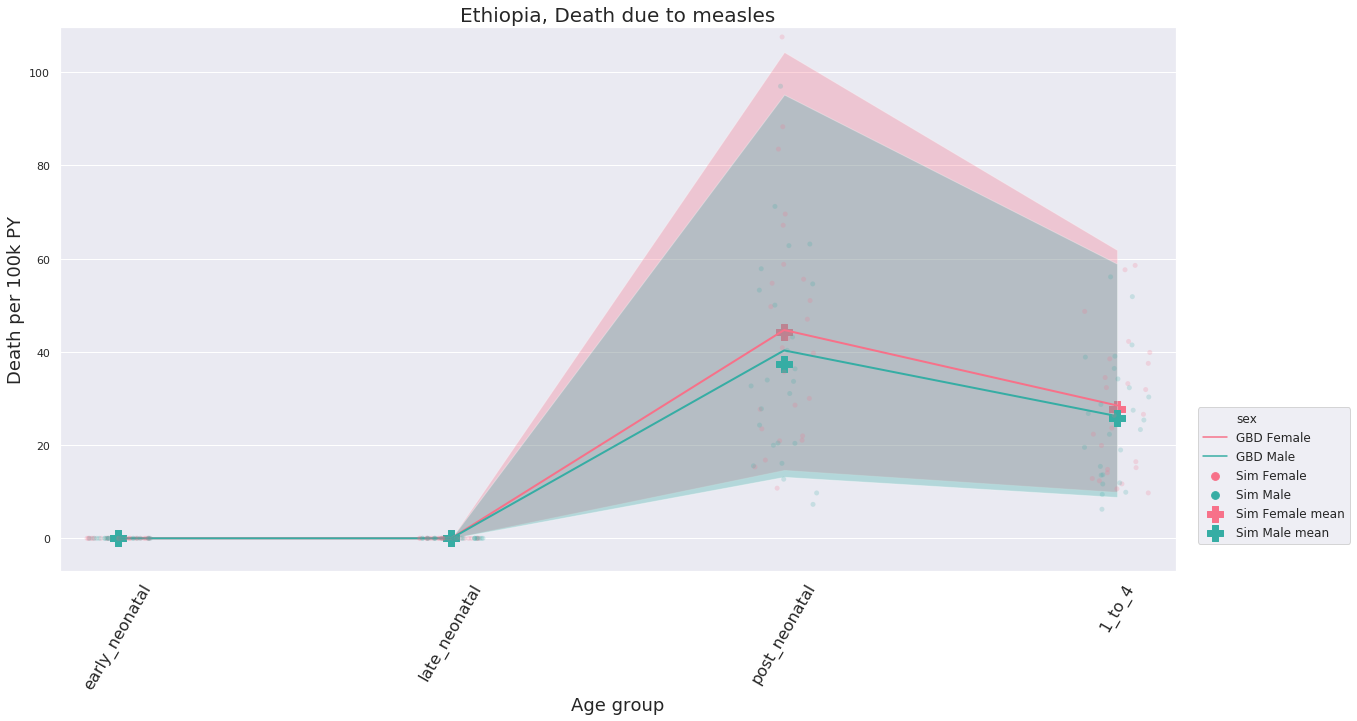

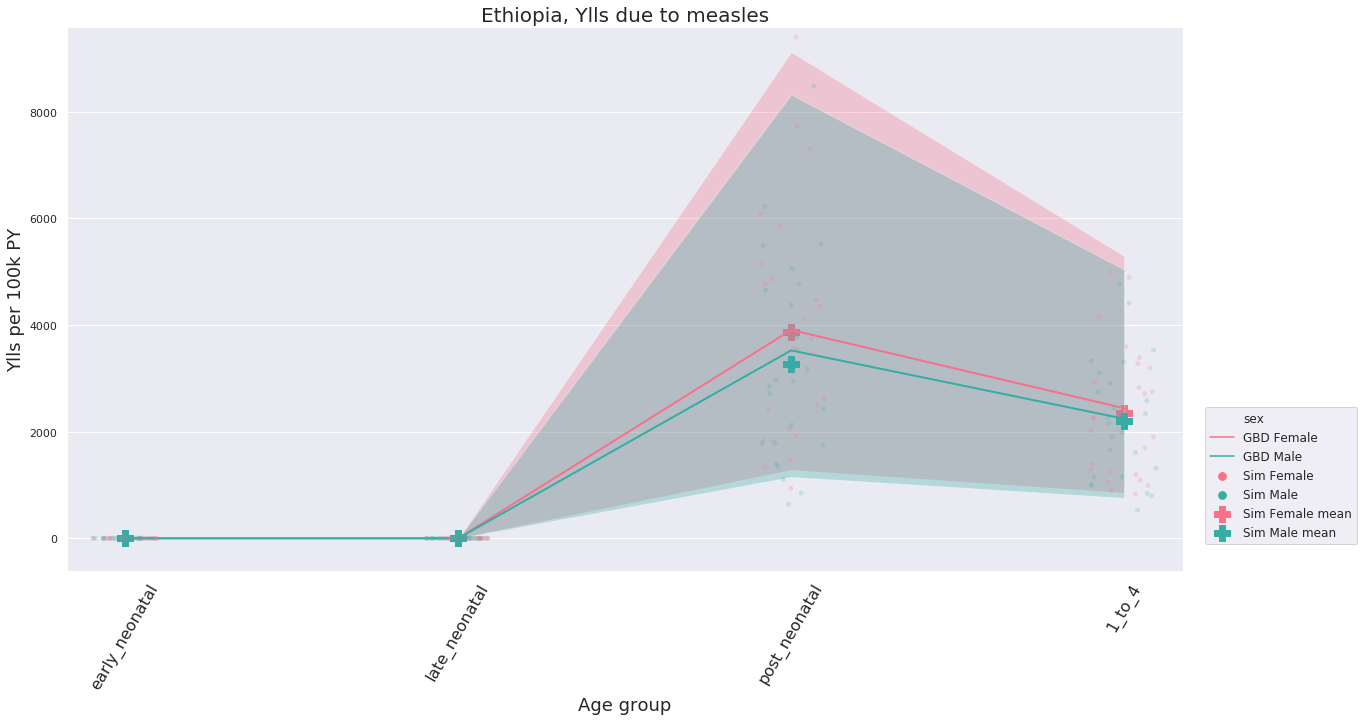

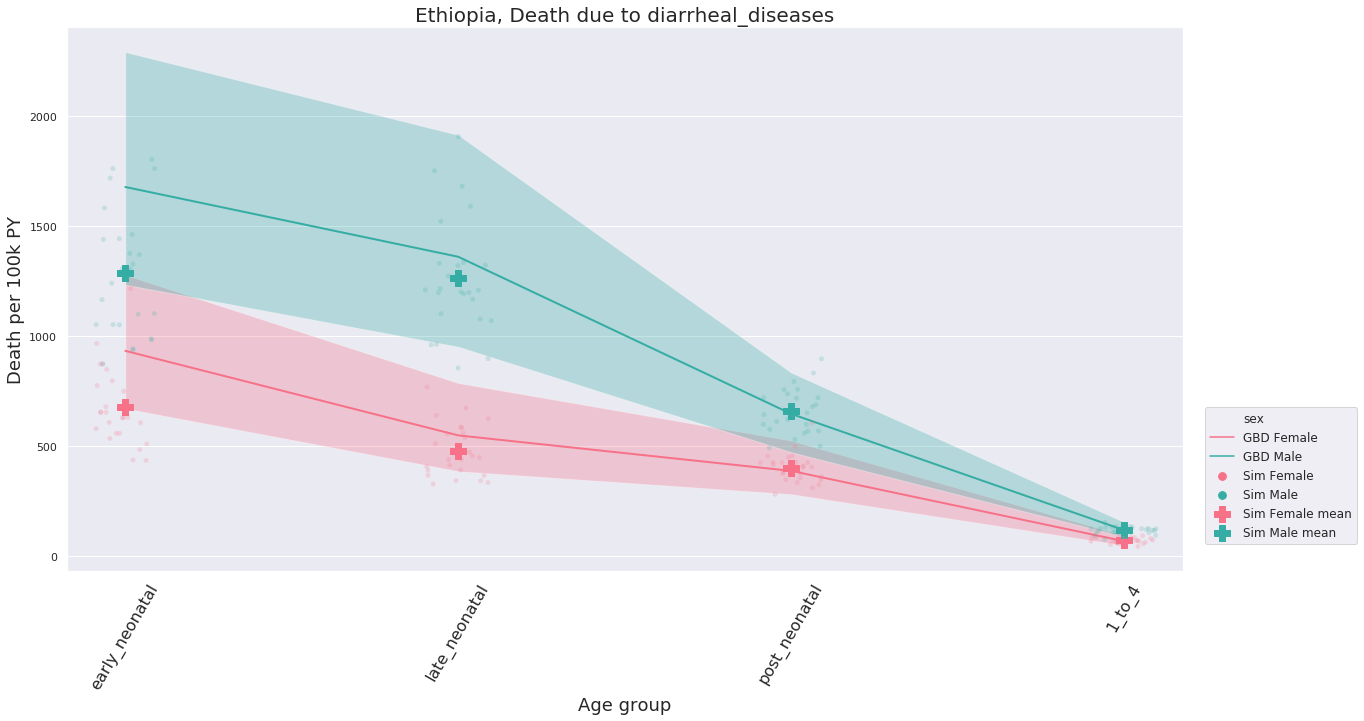

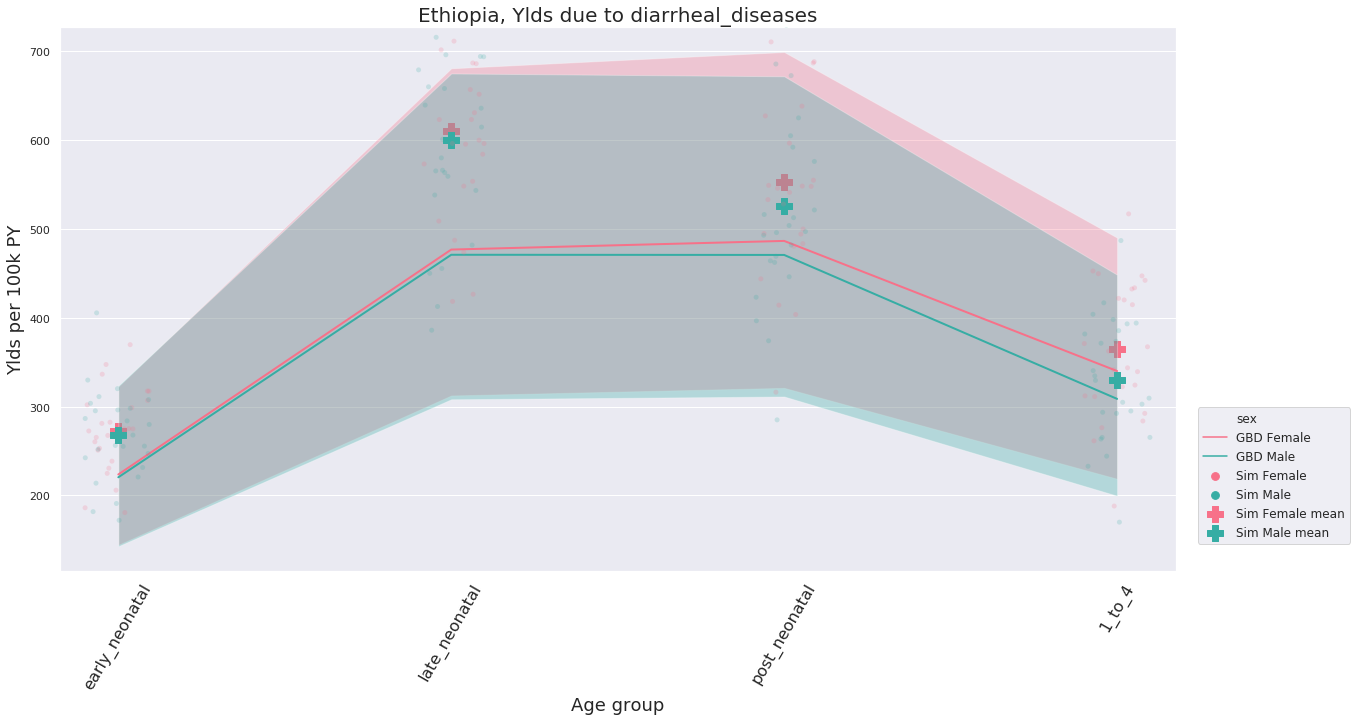

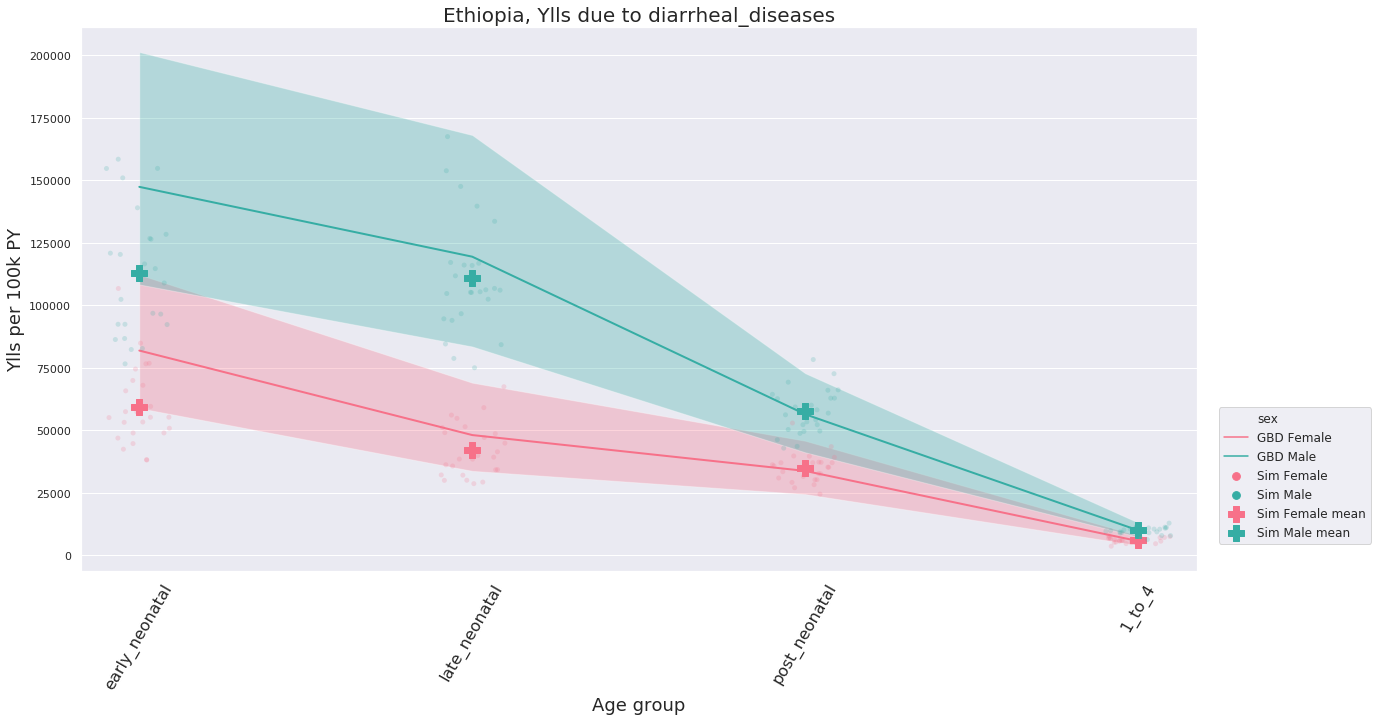

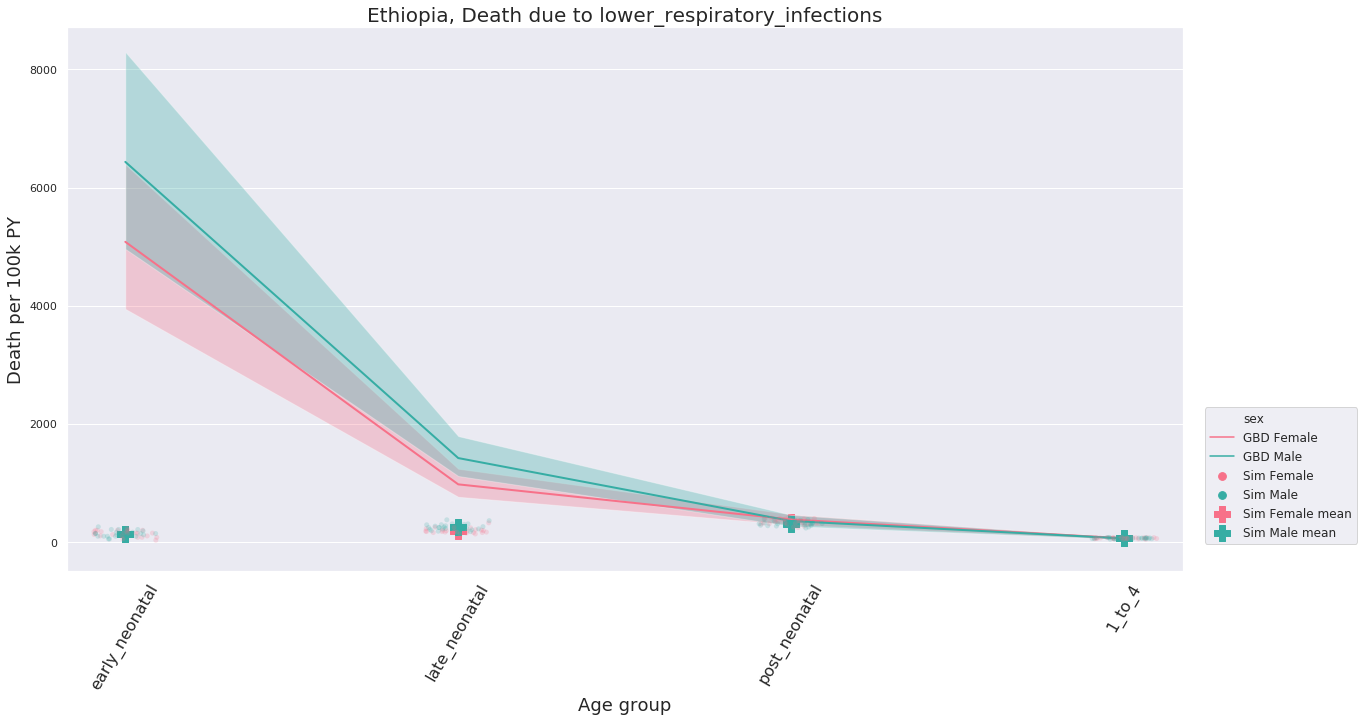

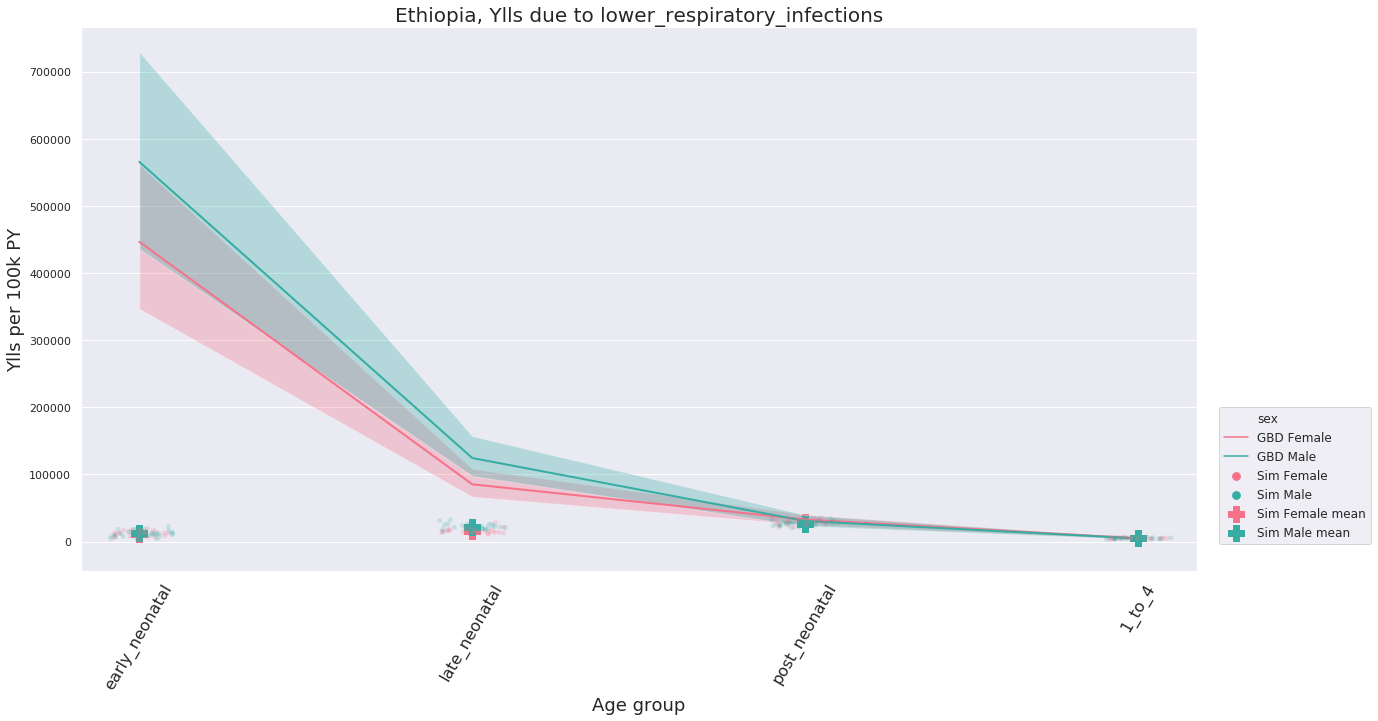

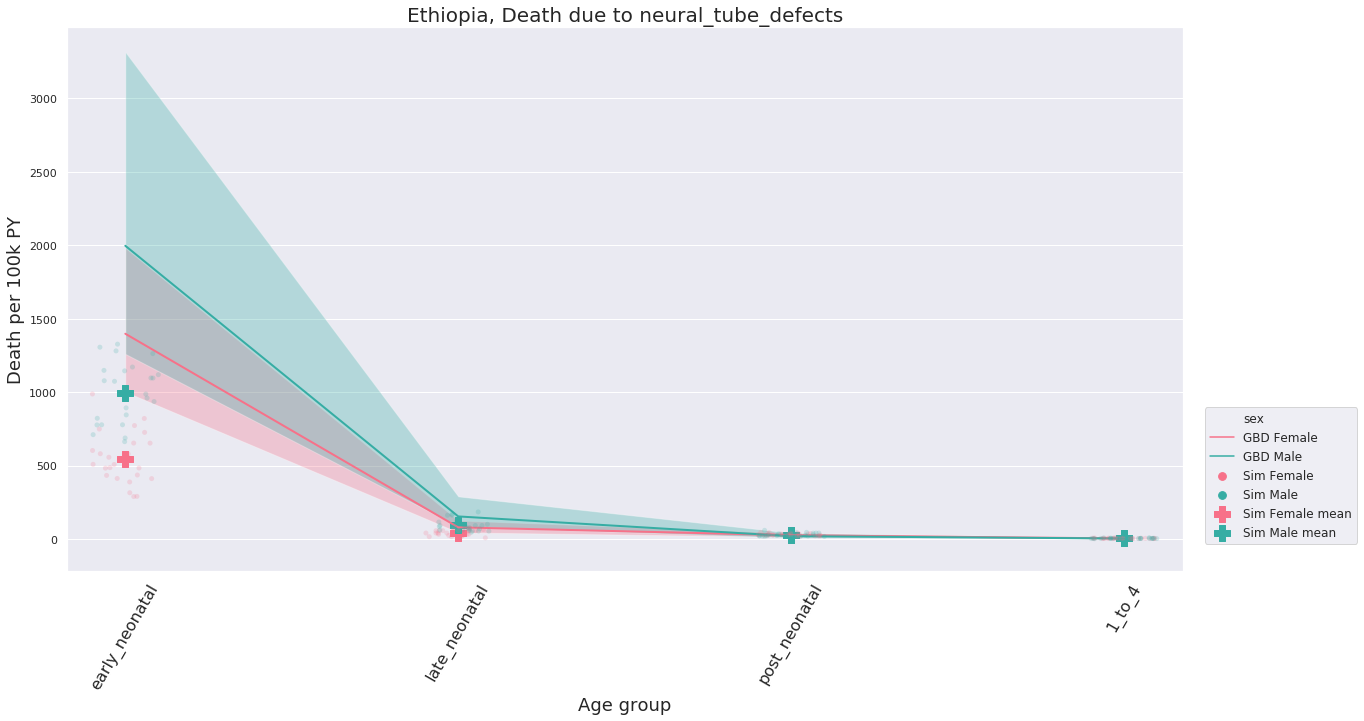

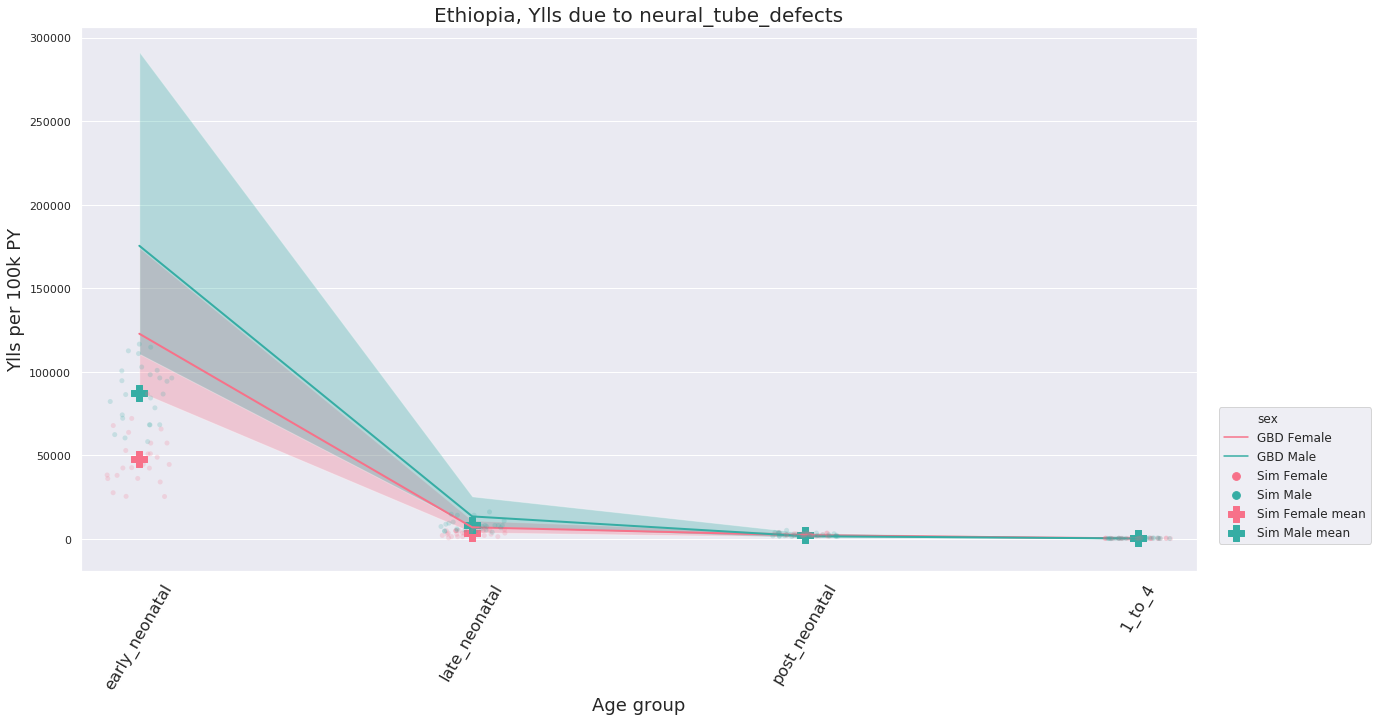

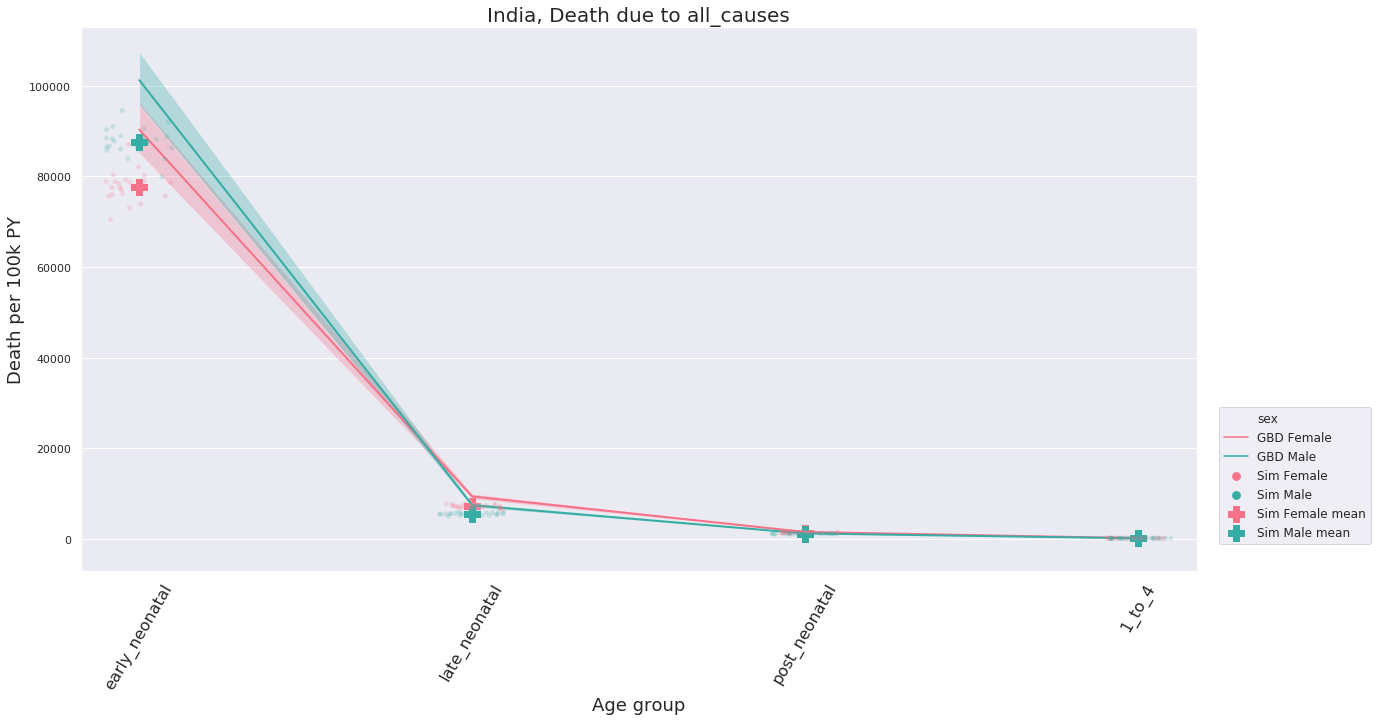

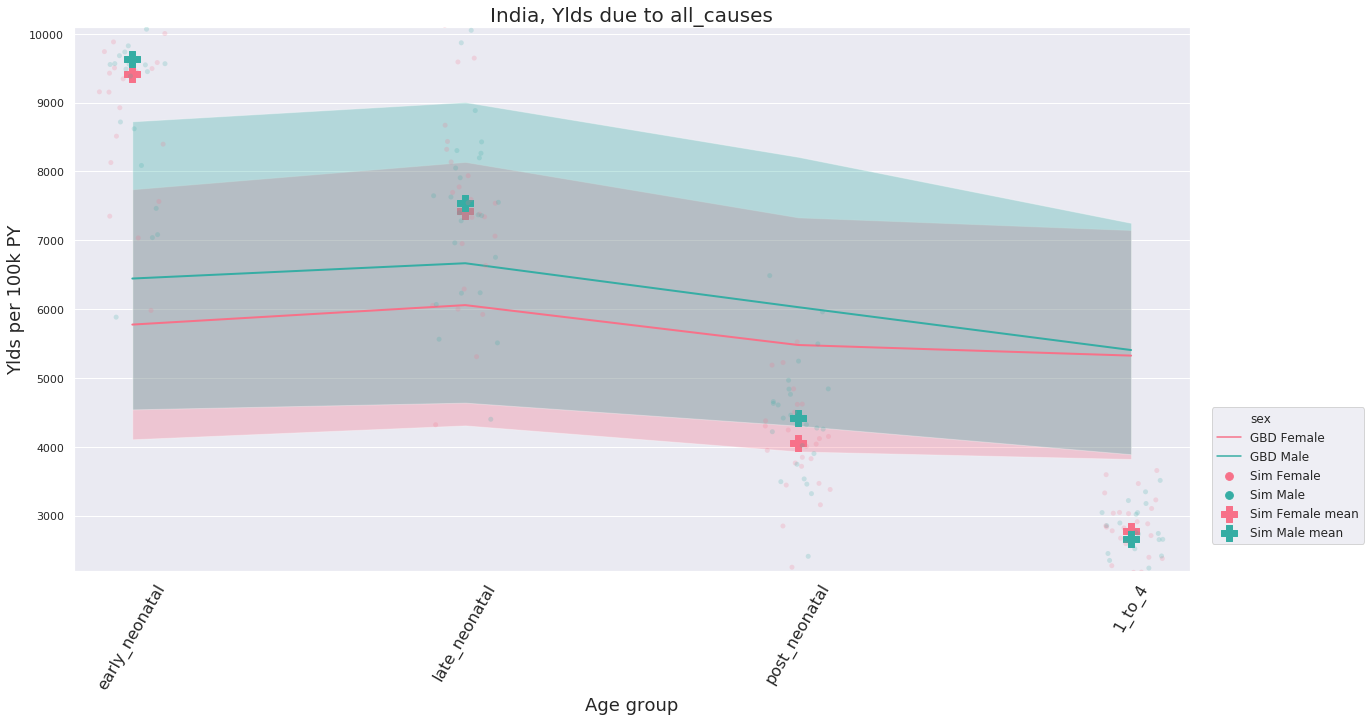

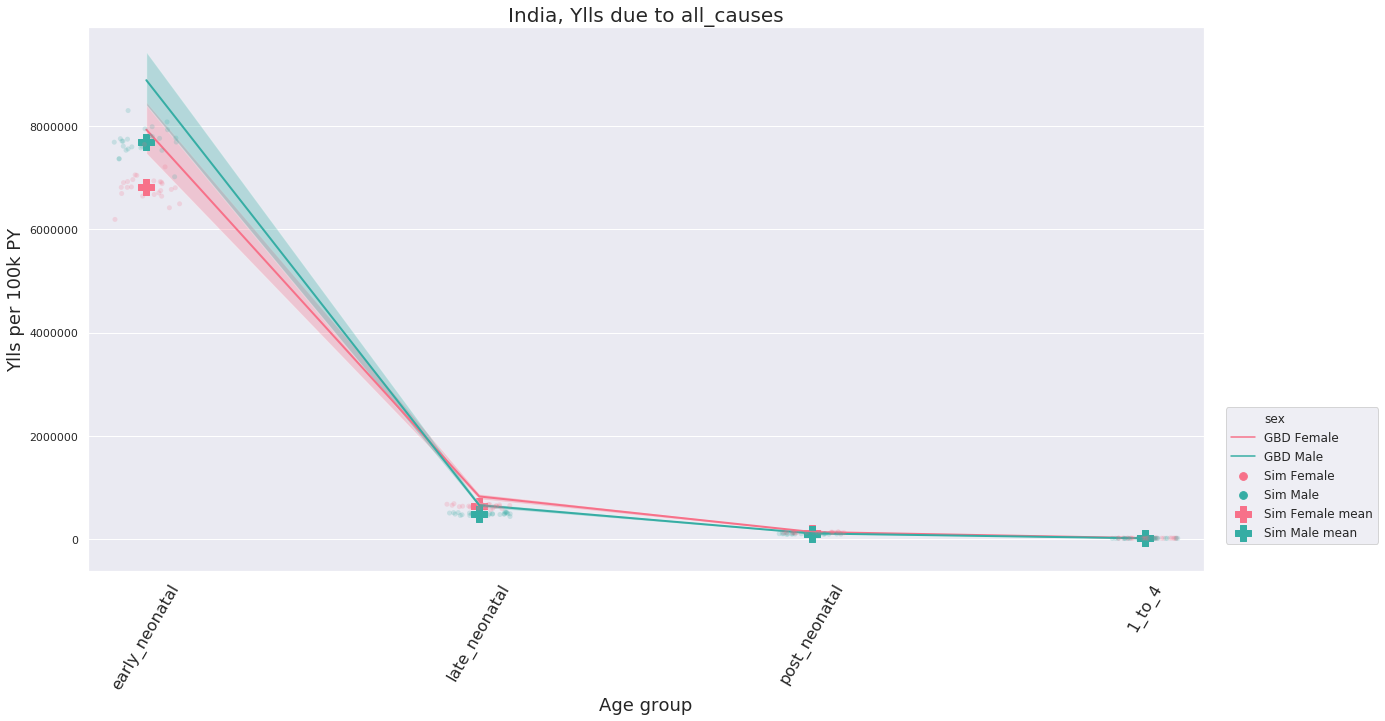

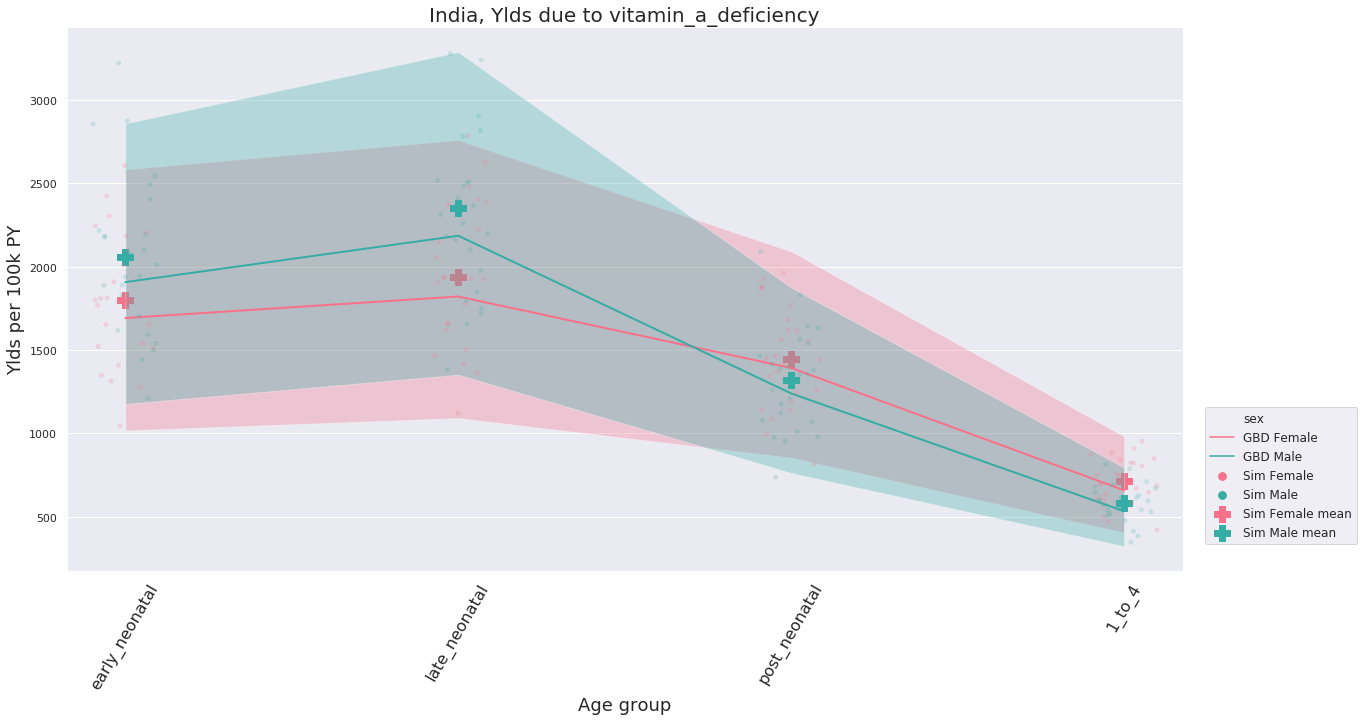

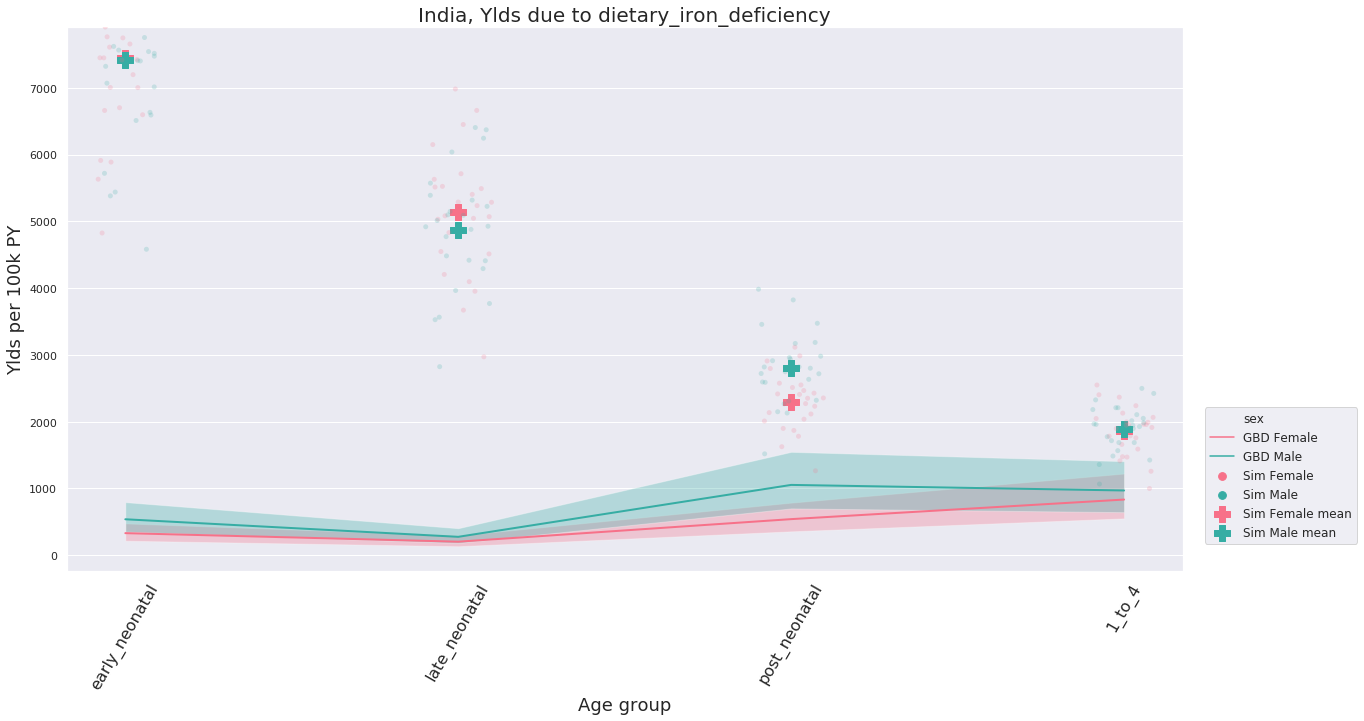

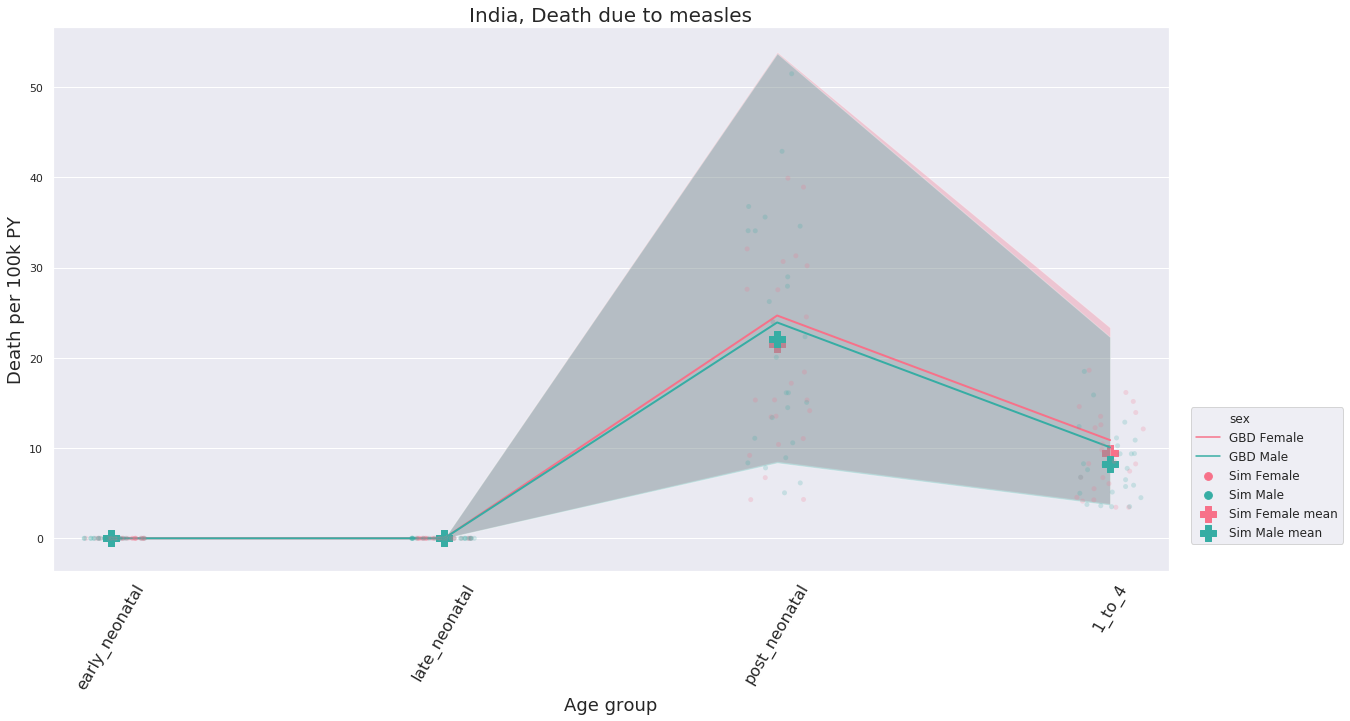

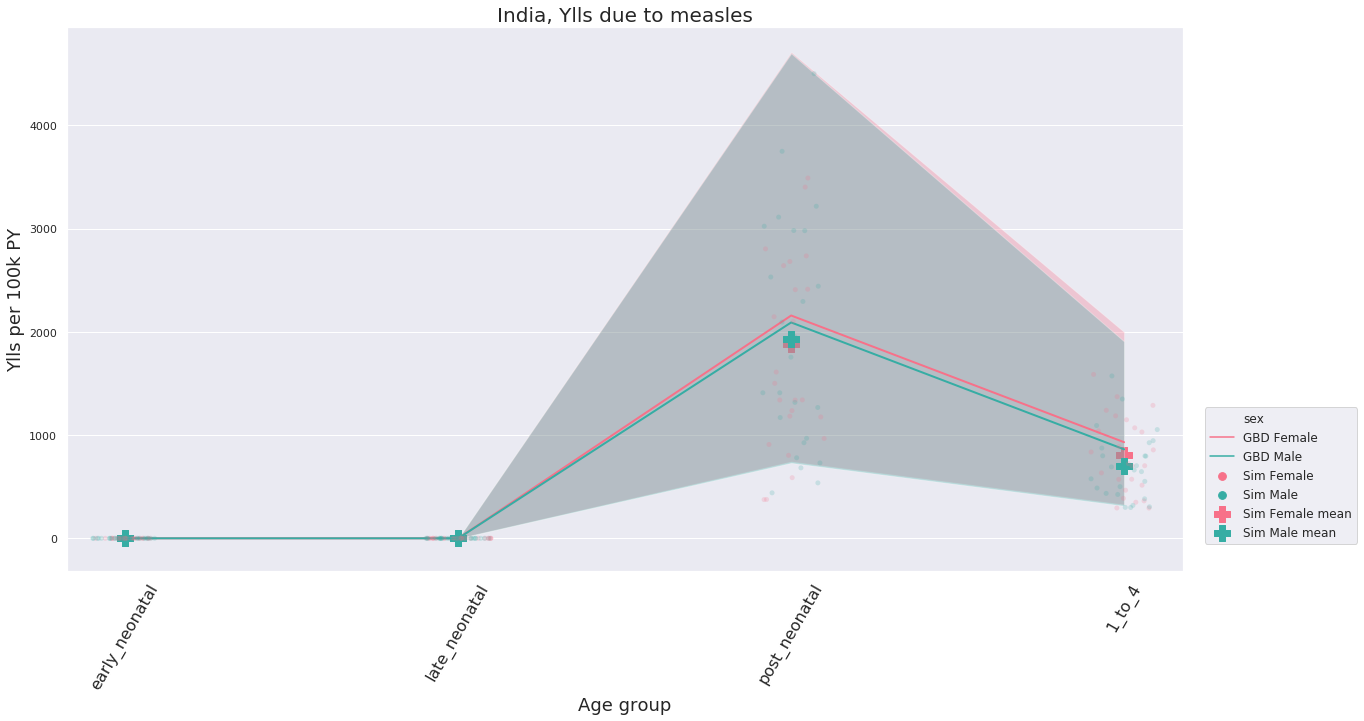

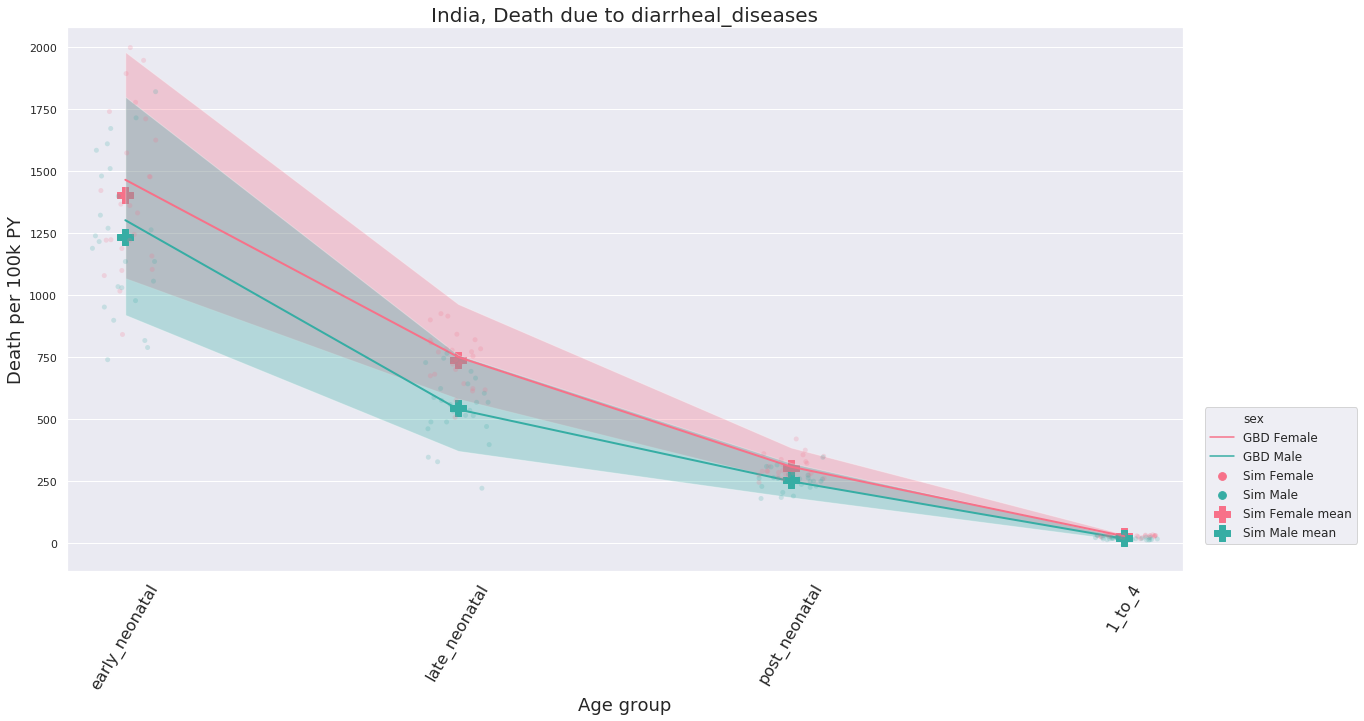

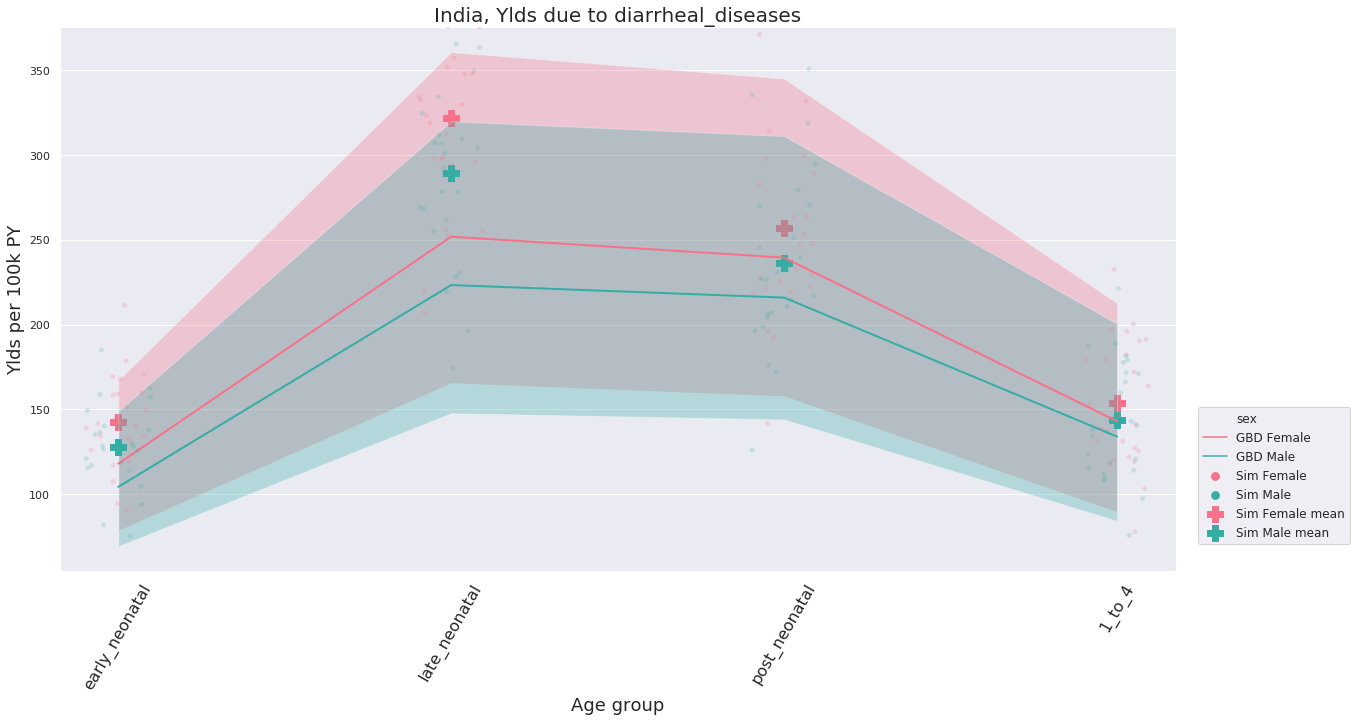

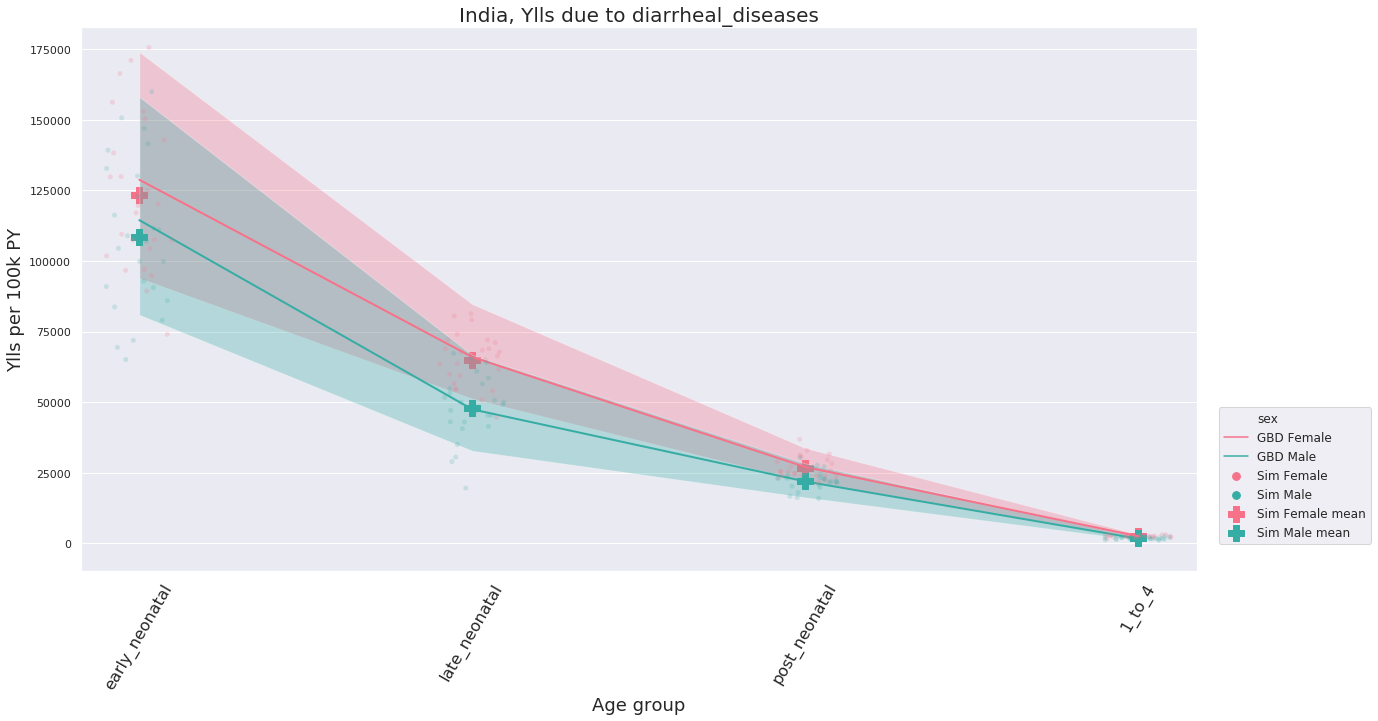

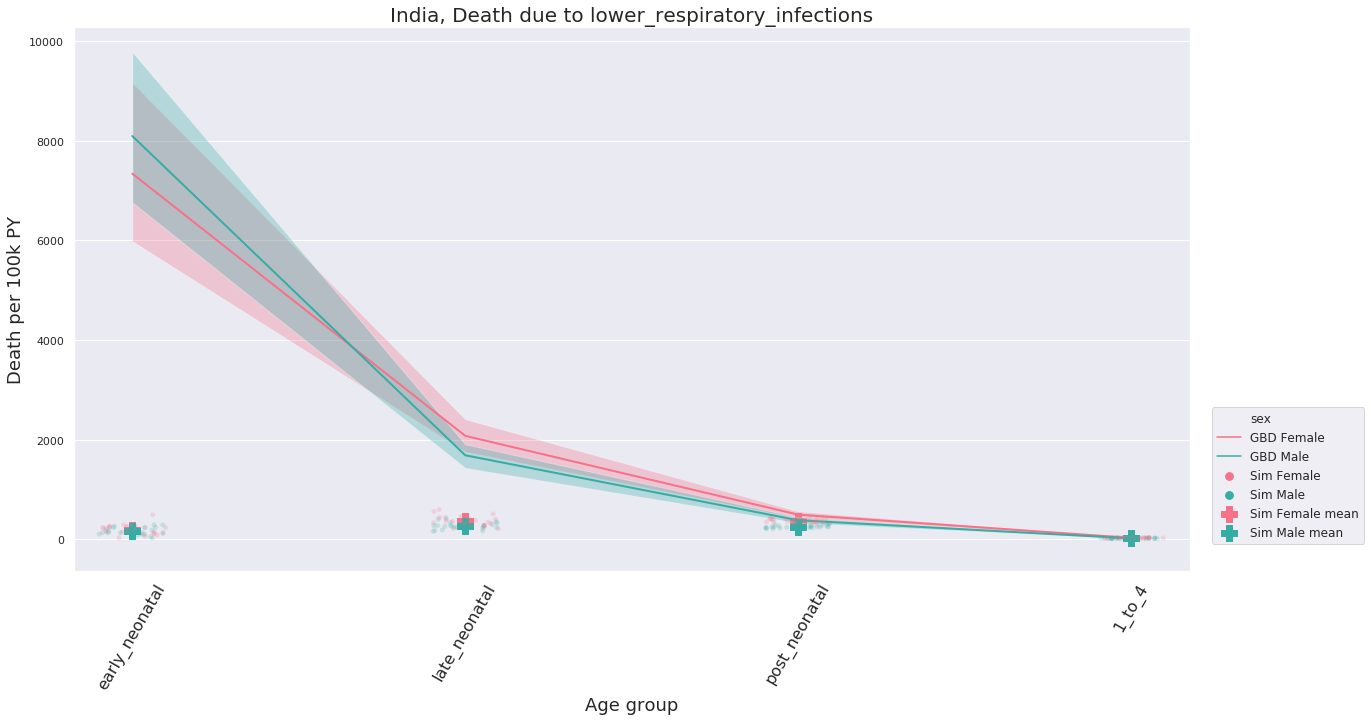

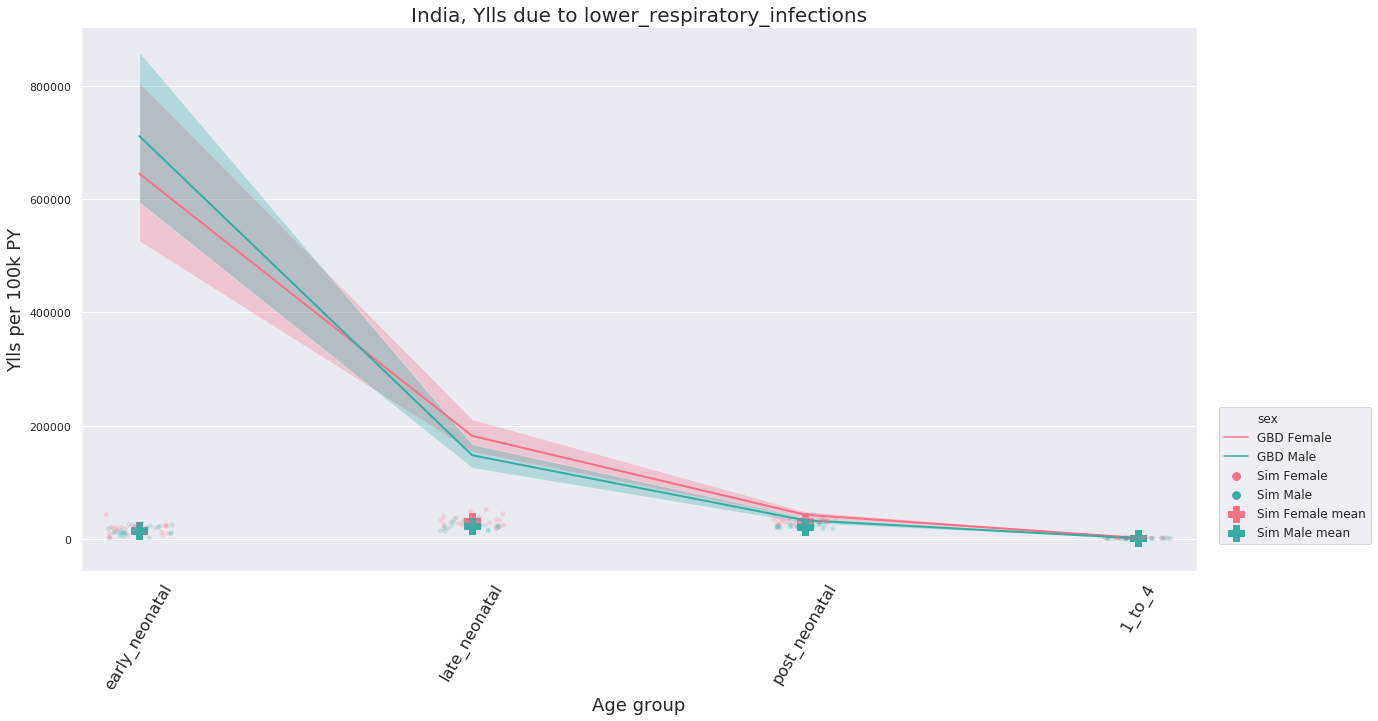

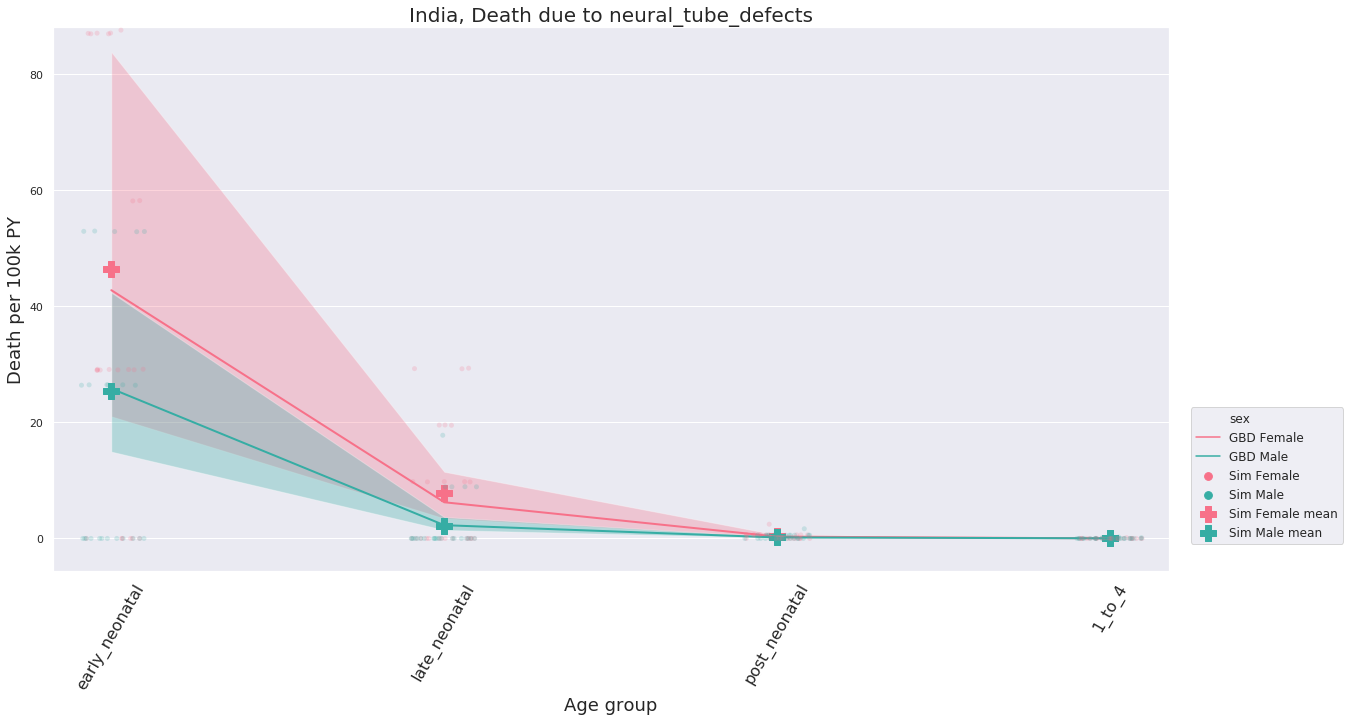

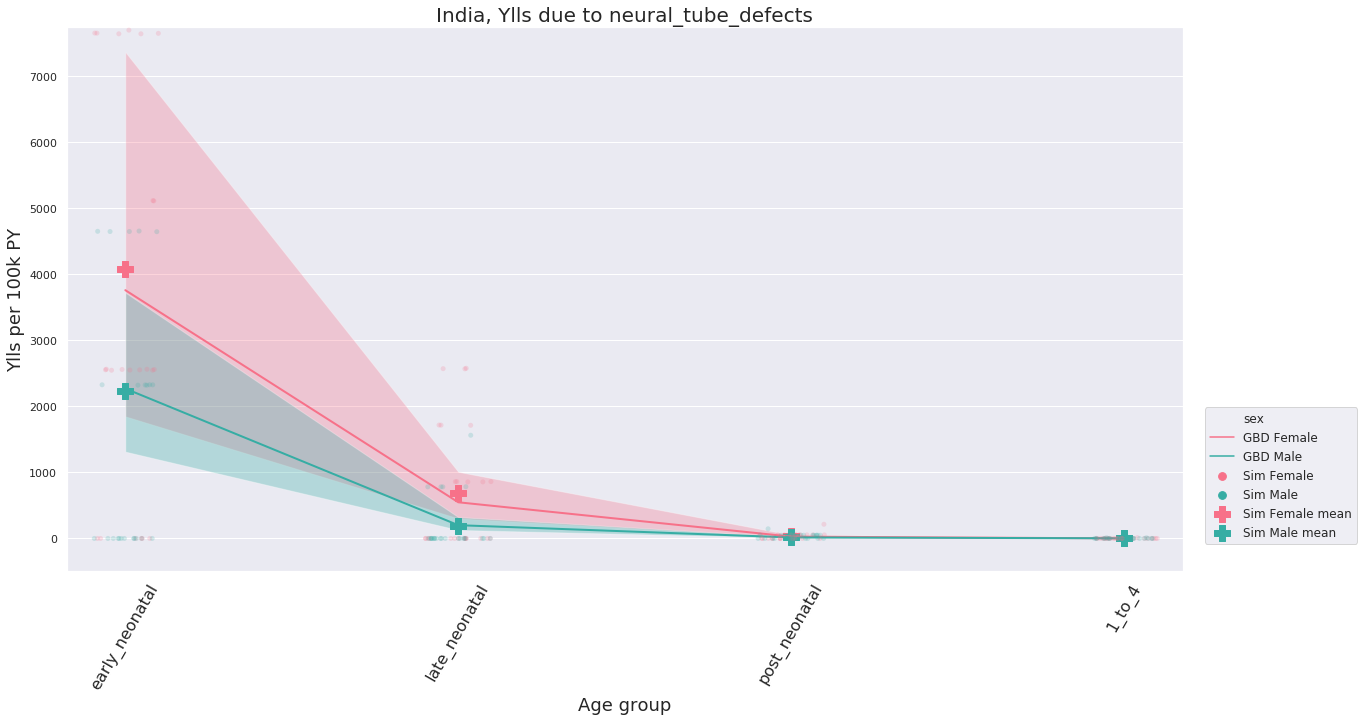

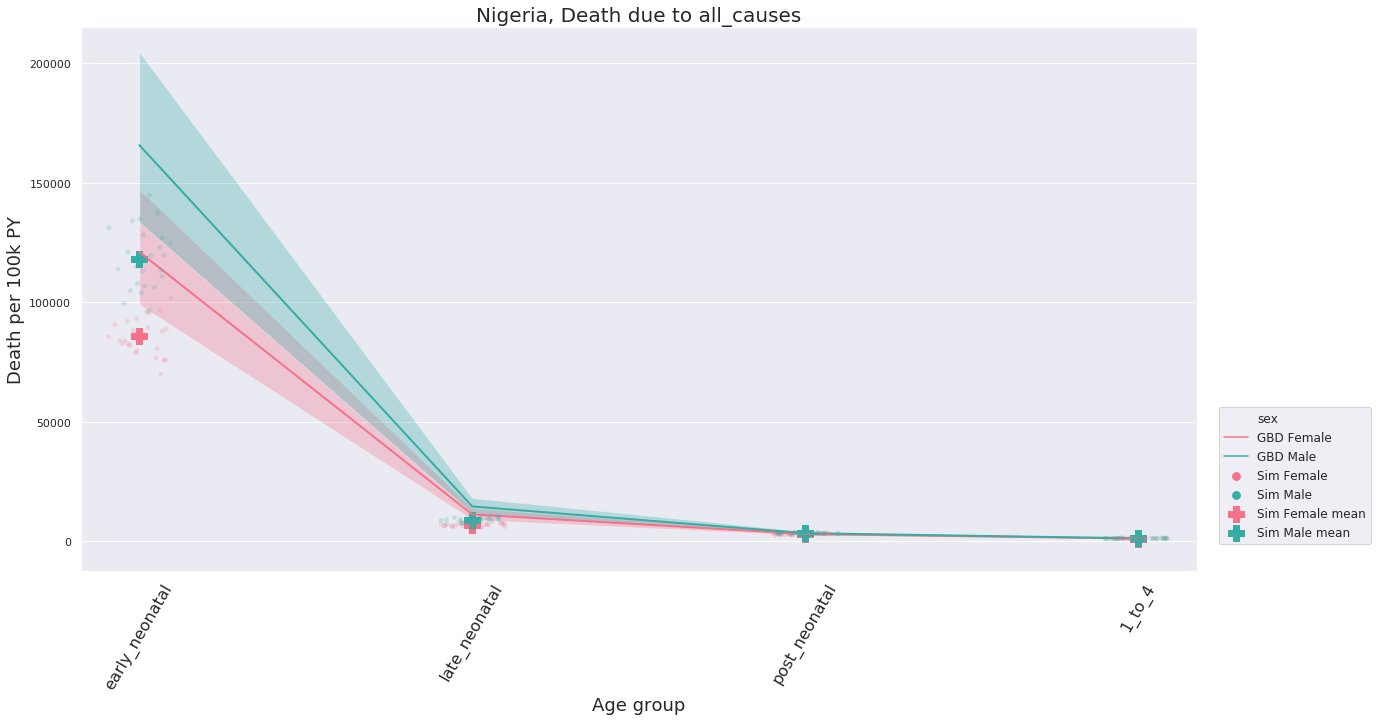

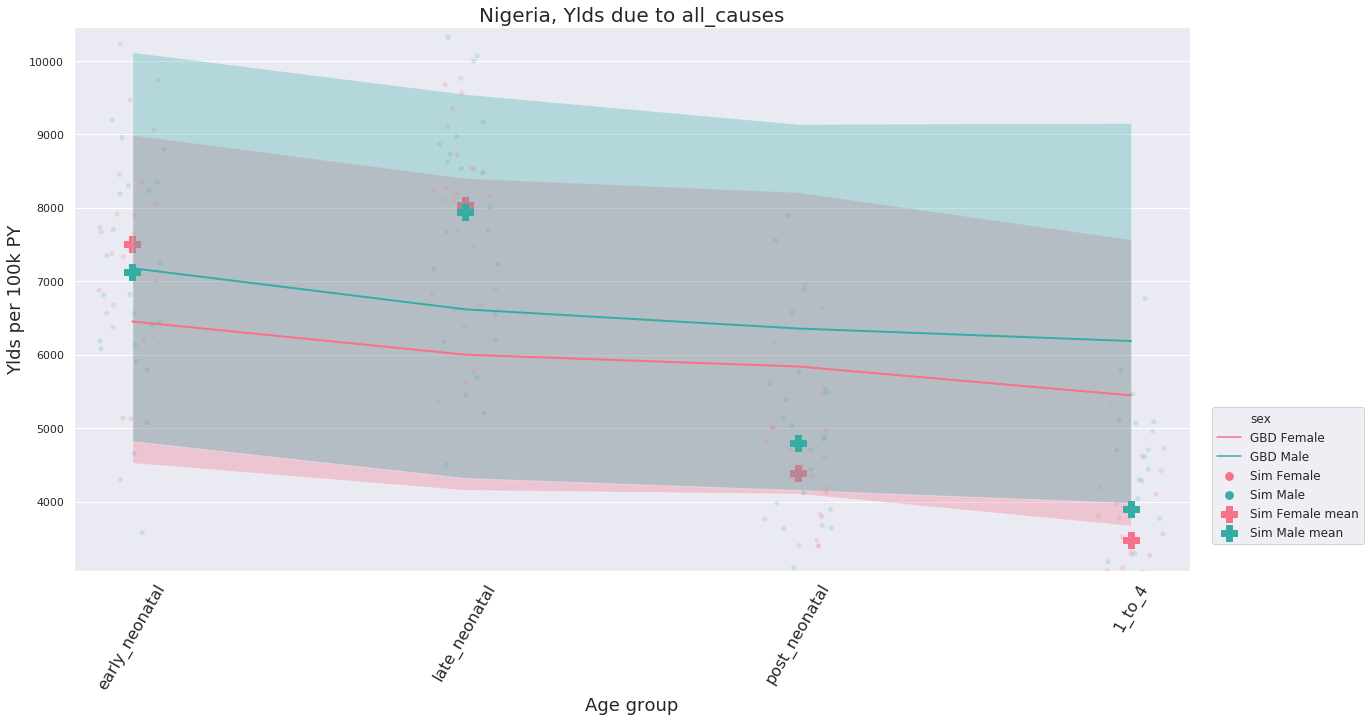

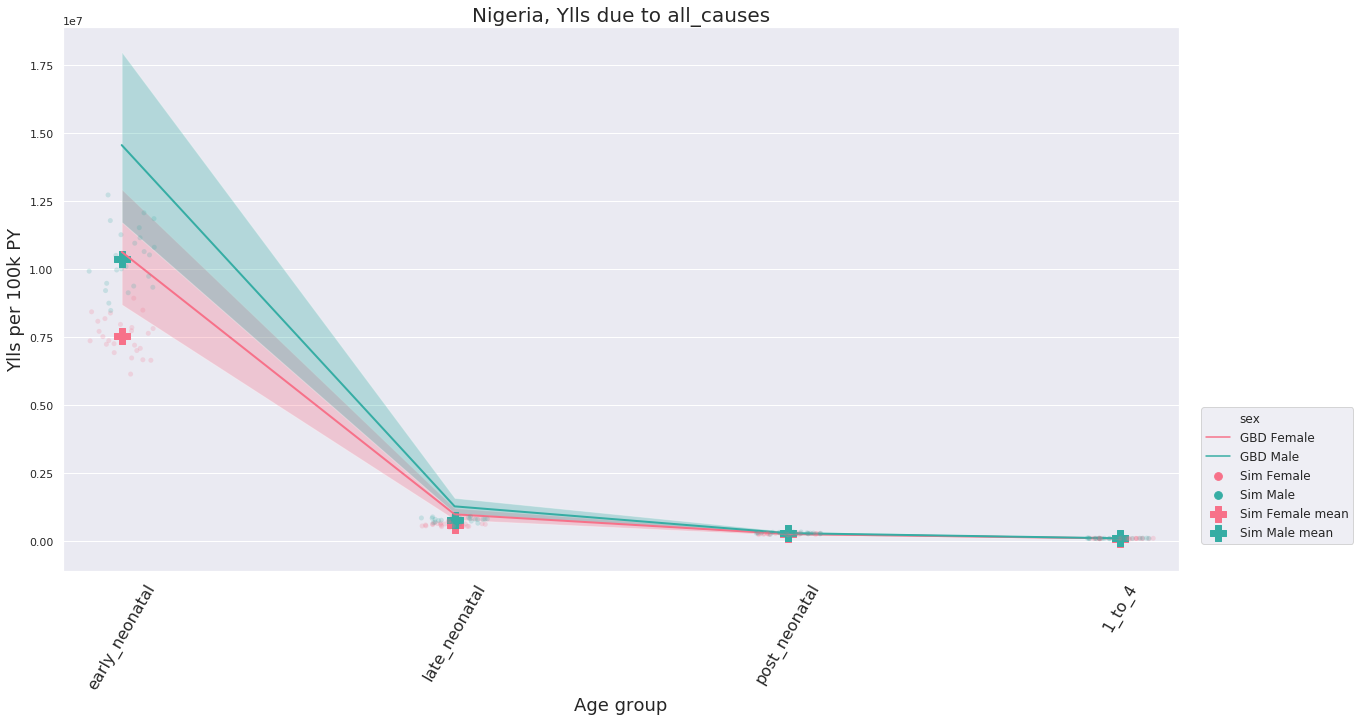

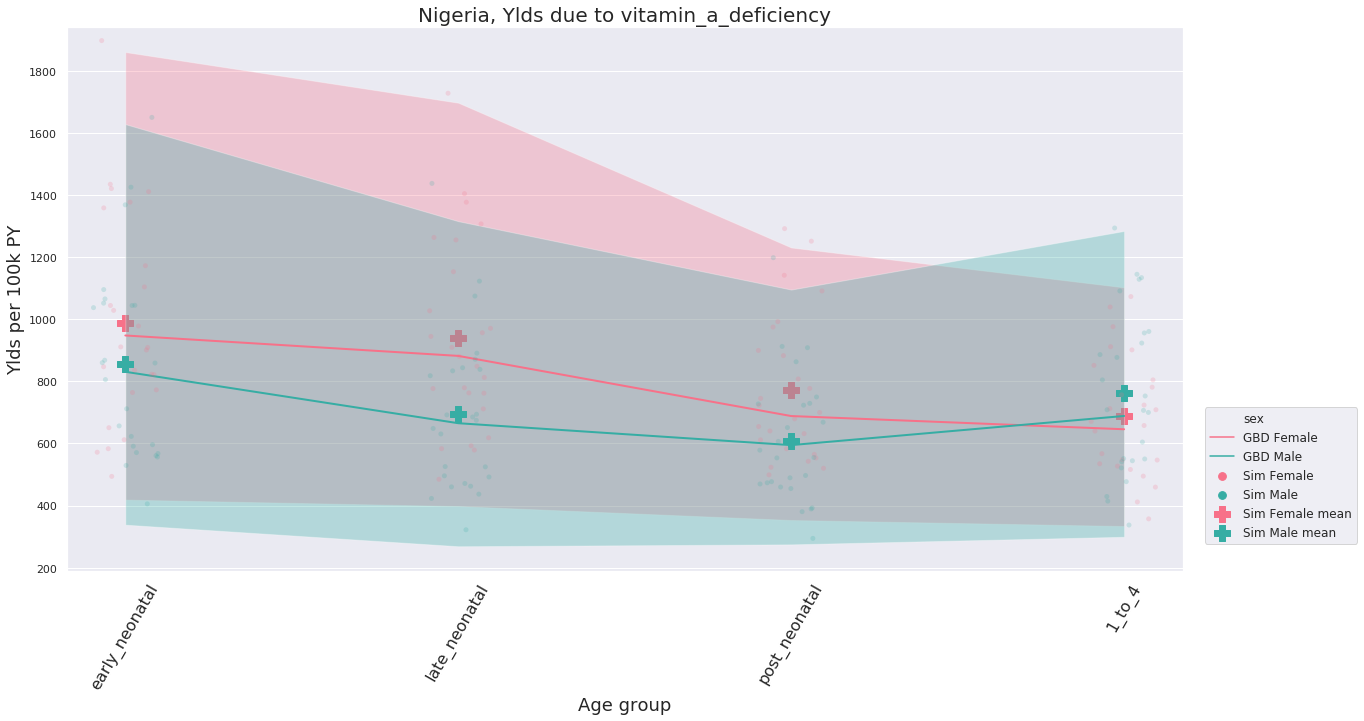

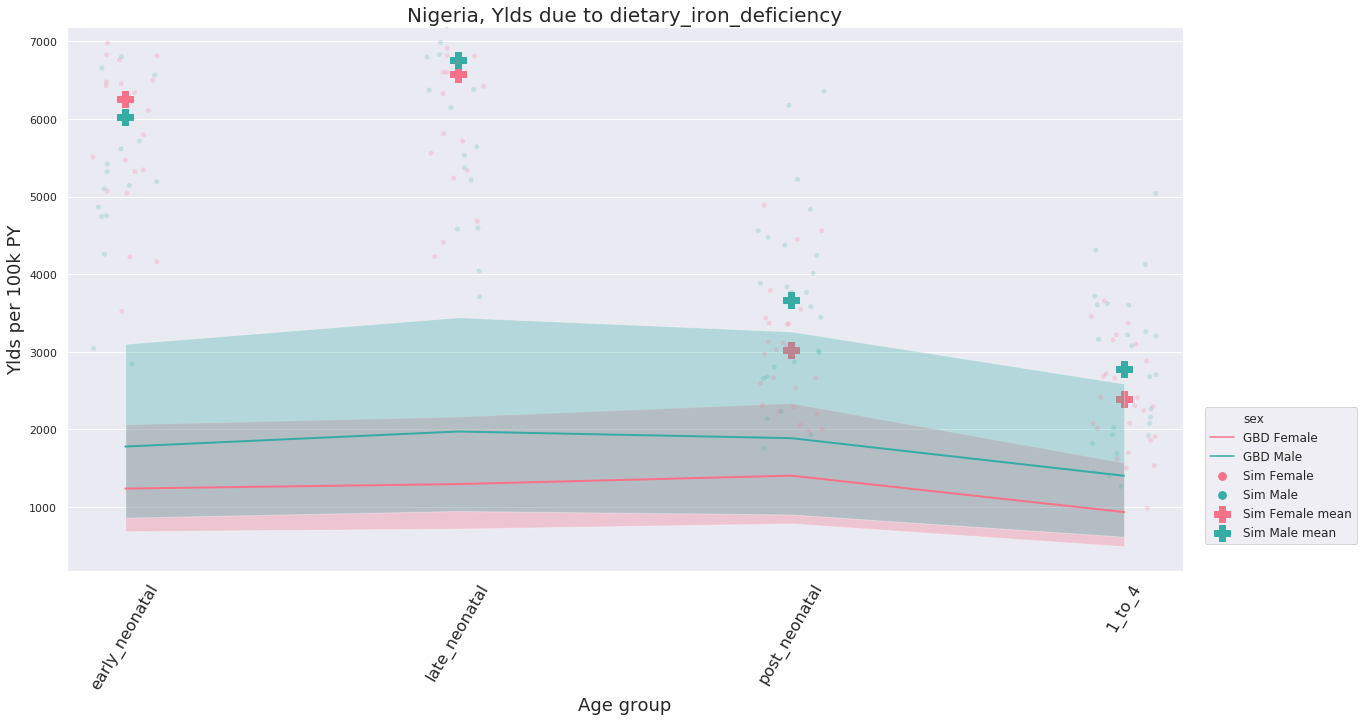

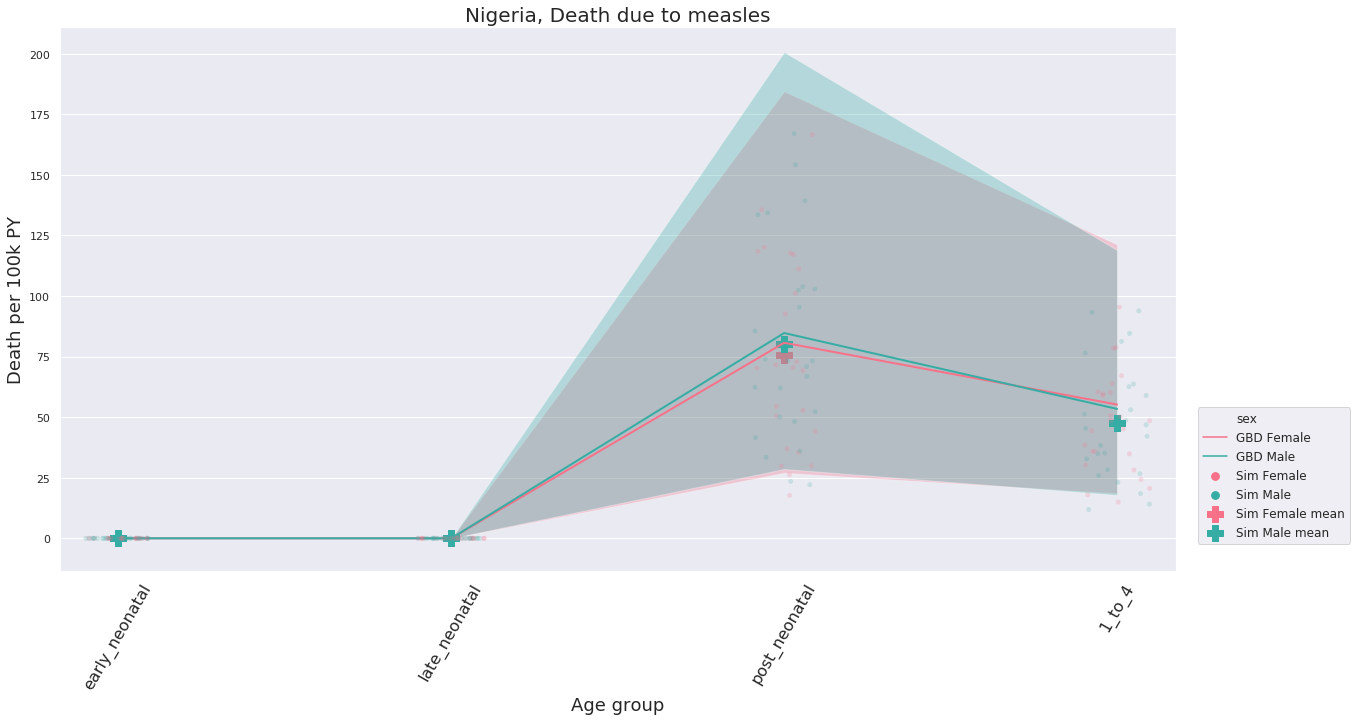

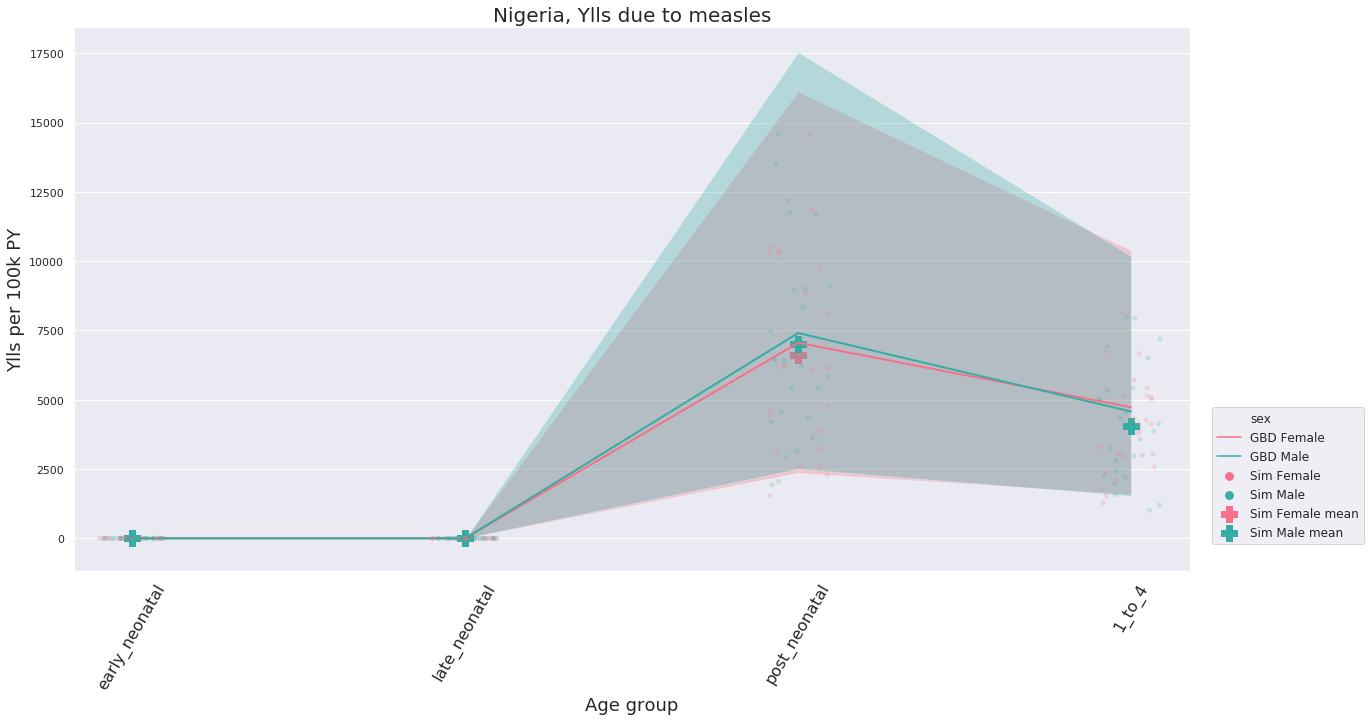

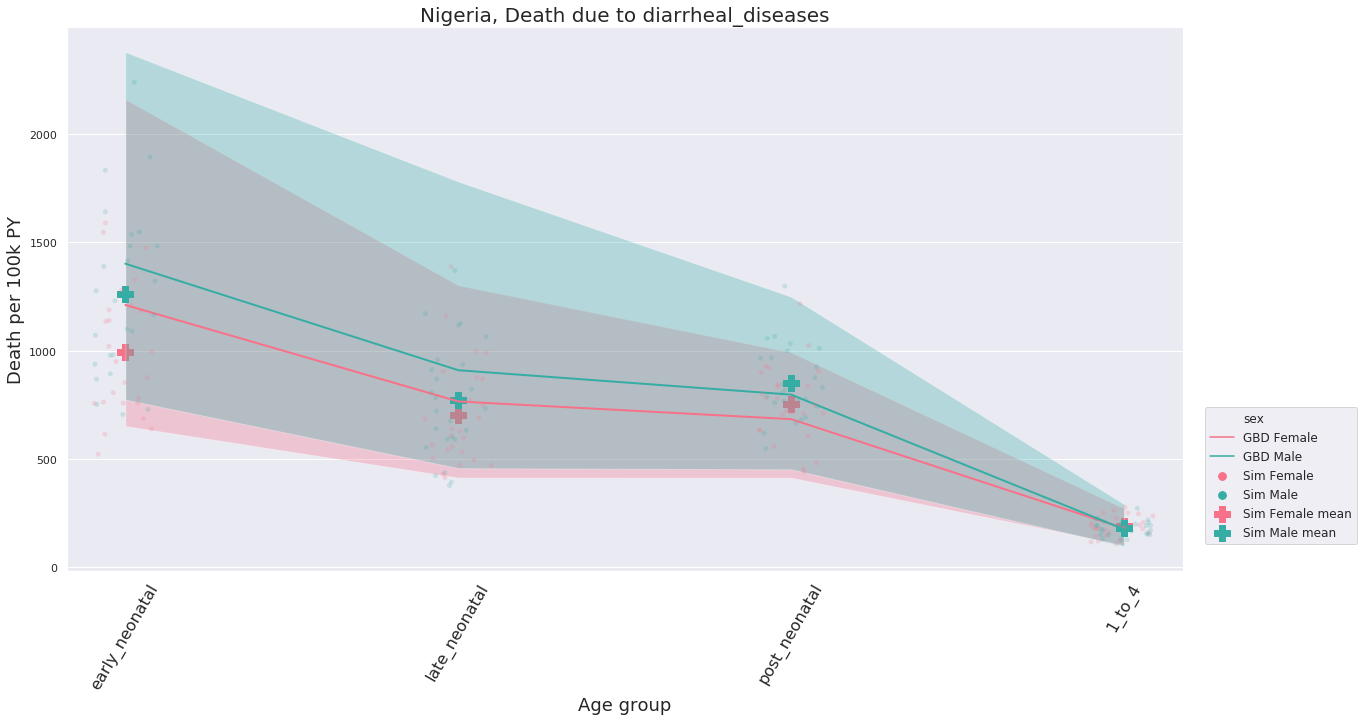

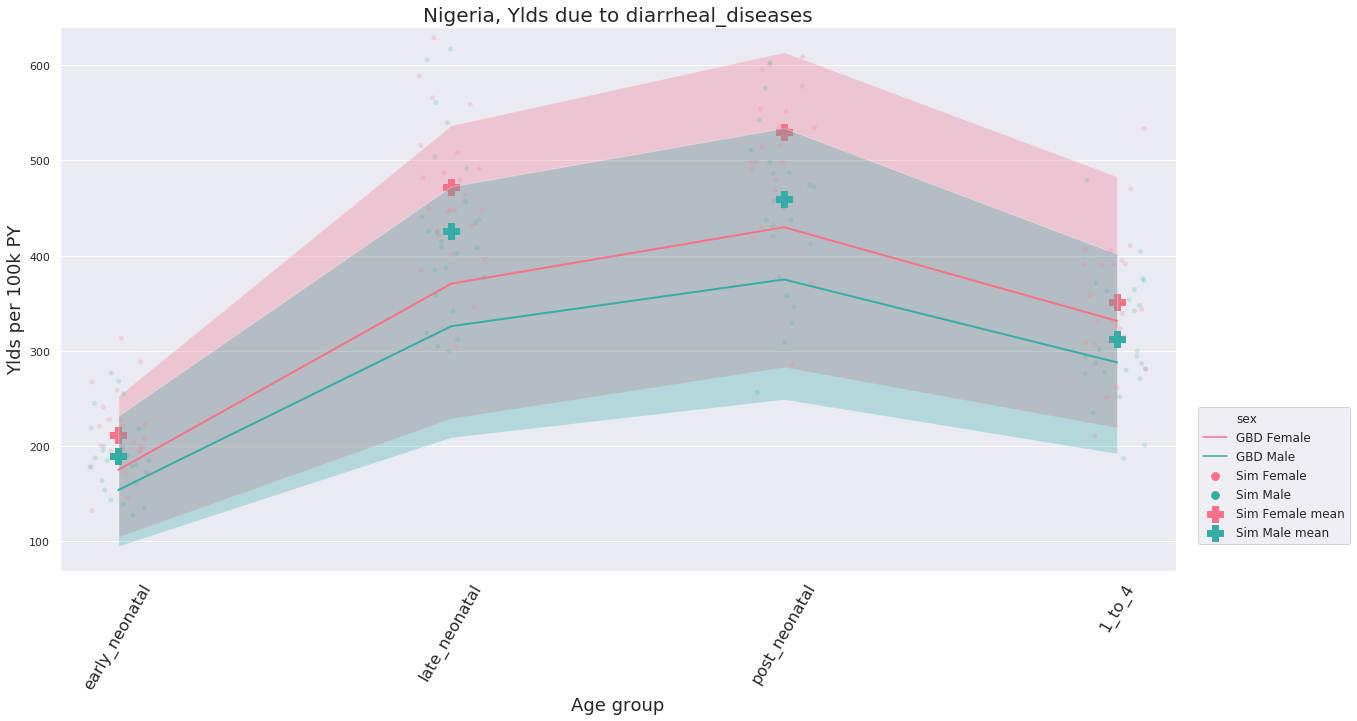

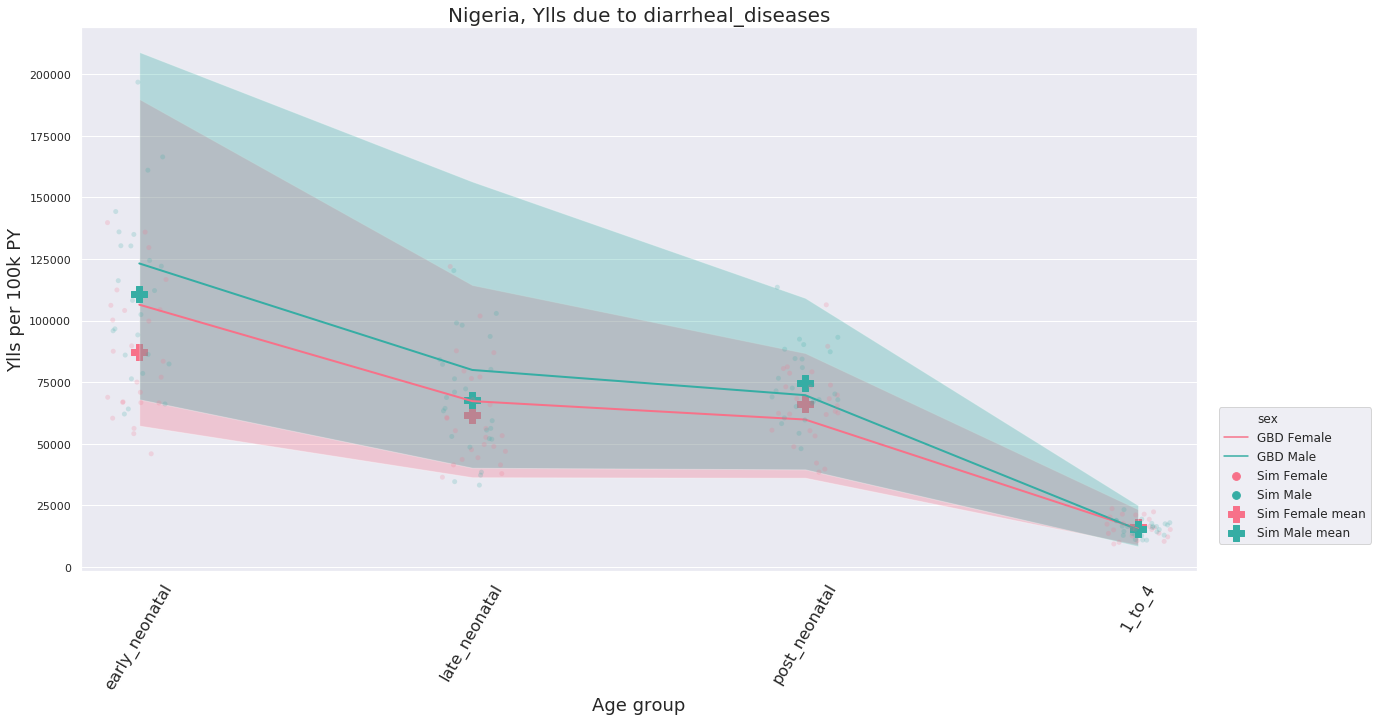

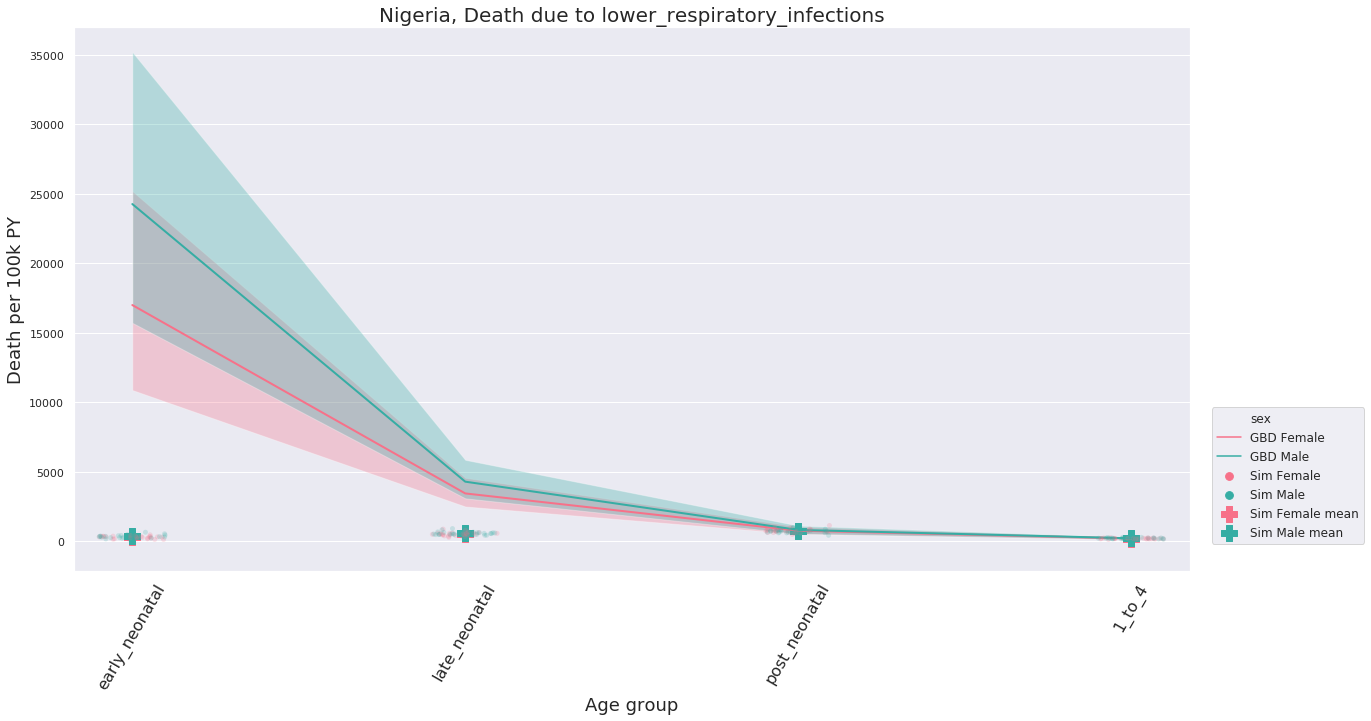

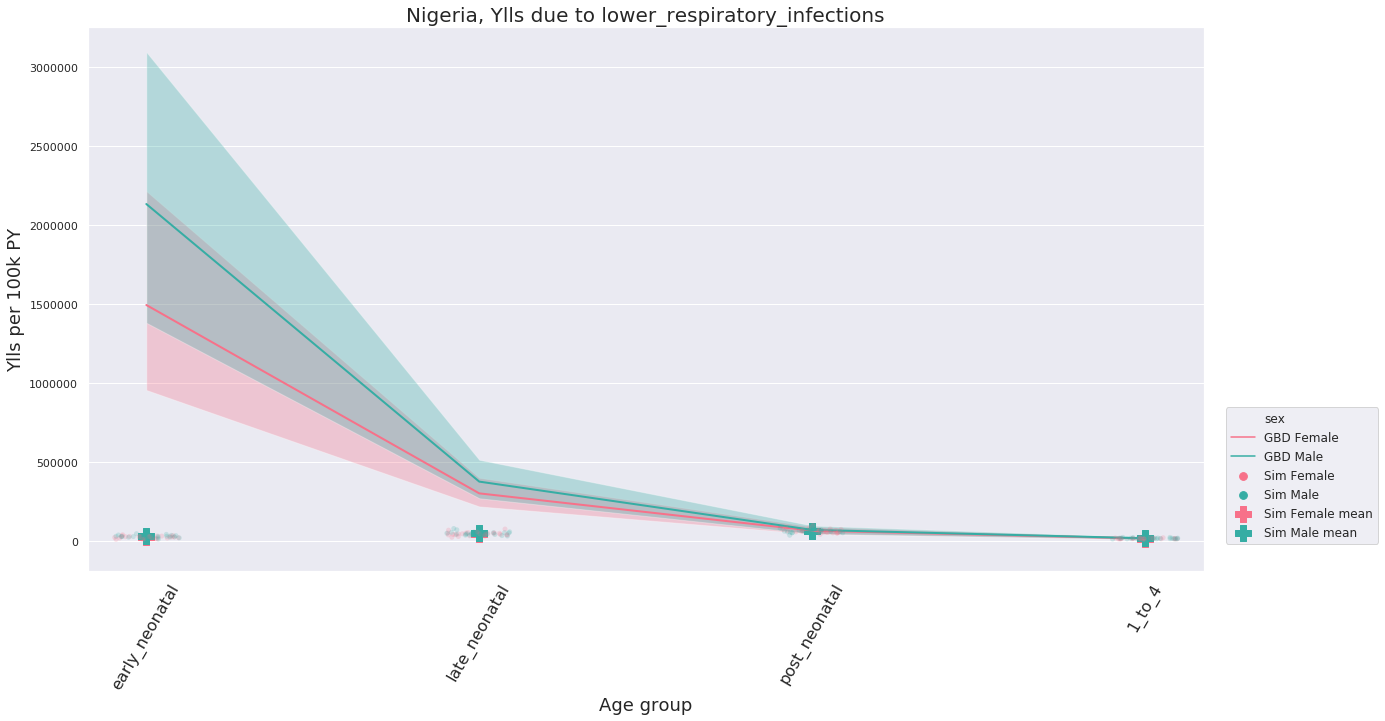

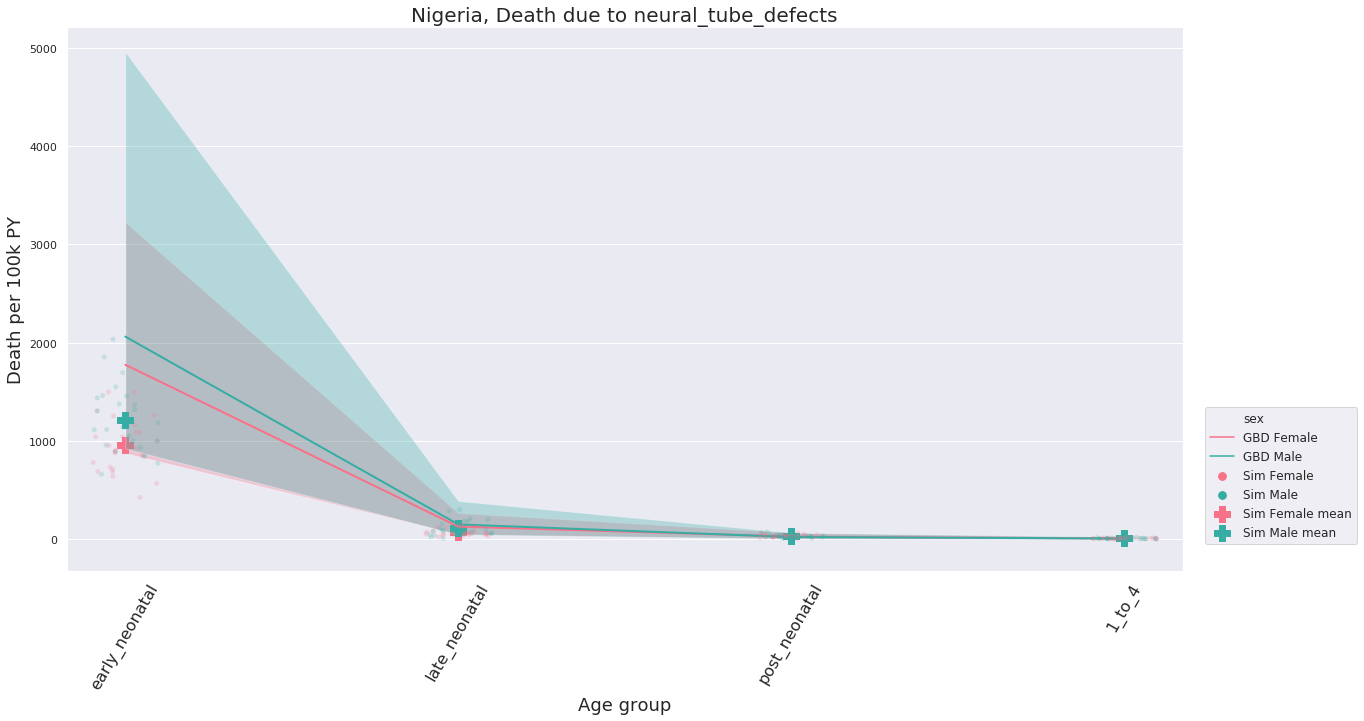

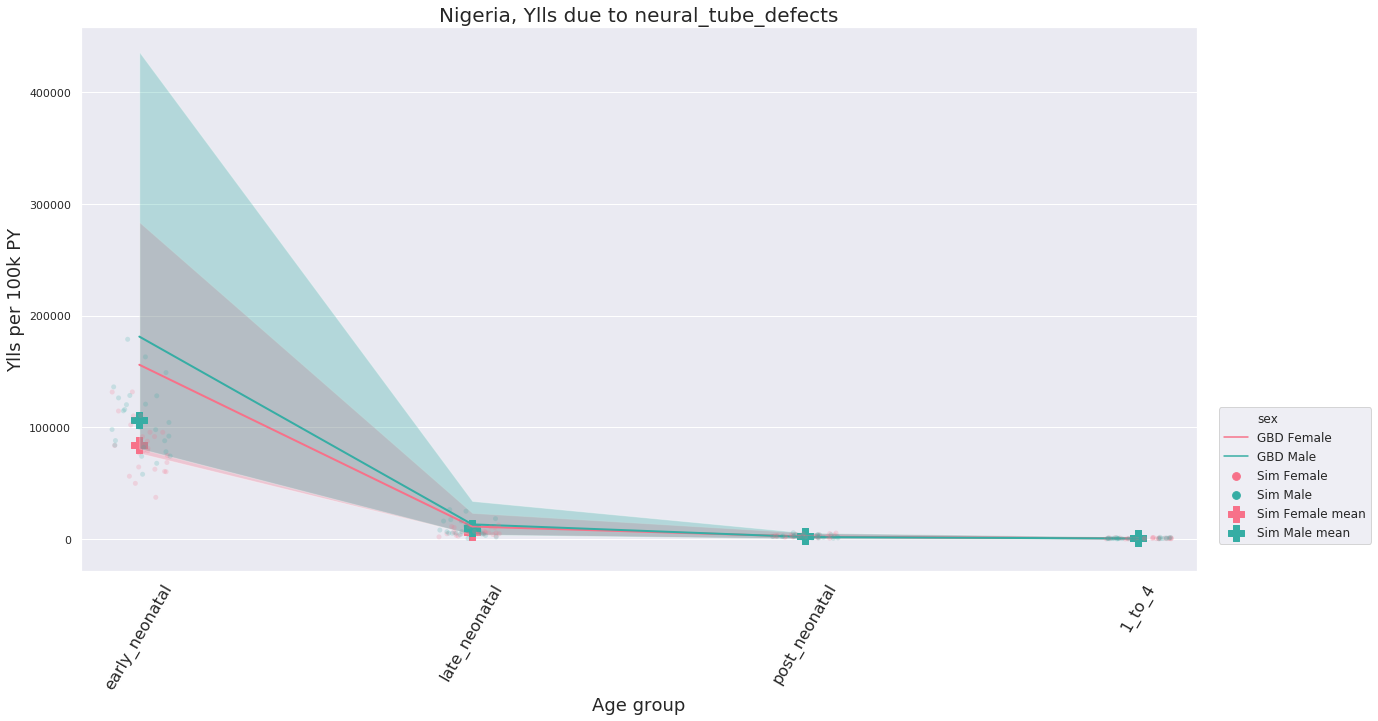

In [18]:
plot_multiple_locations(filePath, cause_names, gbd_names)